# Proyecto 03 - Procesamiento de Lenguaje Natural

## <i>Dataset</i>: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el <i>dataset</i> de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el <i>dataset</i> [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este <i>dataset</i>.**

### - Exploración de datos y Procesamiento de Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este <i>dataset</i>. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### - <i>Machine Learning</i>

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo <i>benchmark</i> y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con <b>NLTK</b>, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### - Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de <i>Machine Learning</i> en un problema binario? Es decir, asignar únicamente las etiquetas <i><b>Positiva</b></i> y <i><b>Negativa</b></i> a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Piensa en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y lee mucho!**

Comenzamos descargando las librerías que a lo largo de este proyecto utilizaremos.

In [1]:
import itertools

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import xgboost as xgb

import spacy

import es_core_news_lg

import nltk

import random

import string

import re

import gc

import warnings
warnings.filterwarnings("ignore")

from spacy.lang.es.stop_words import STOP_WORDS
from spacy.lang.es import Spanish

from spacy.lemmatizer import Lemmatizer

from spacy.lookups import Lookups

from collections import Counter

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.decomposition import PCA

from xgboost import XGBClassifier

from IPython.core.display import display, HTML

Ahora, carguemos el <i>dataset</i> con el que trabajaremos y veamos los últimos cinco registros.

In [2]:
dataset = pd.read_json('dataset_es_train.json', lines = True)
dataset.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
199995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics
199996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics
199997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel
199998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy
199999,es_0859809,product_es_0378794,reviewer_es_0141717,5,"Súper bien! Las brochas son buenas, no sé meno...",Preciosas,es,home


## Parte A - Exploración de Datos

**- <i>Dataset Train</i>**

Probablemente la variable `product_category` pueda ser útil más adelante. Para homologar el idioma, convertiremos sus valores al español.

Veamos qué valores toma.

In [3]:
dataset.product_category.unique()

array(['electronics', 'drugstore', 'wireless', 'shoes', 'home', 'luggage',
       'office_product', 'kitchen', 'pc', 'toy', 'industrial_supplies',
       'furniture', 'pet_products', 'sports', 'home_improvement',
       'grocery', 'lawn_and_garden', 'beauty', 'other', 'watch',
       'automotive', 'book', 'apparel', 'video_games', 'camera',
       'baby_product', 'personal_care_appliances', 'jewelry',
       'digital_ebook_purchase', 'musical_instruments'], dtype=object)

Ahora, hagamos un diccionario para traducir estos valores.

In [4]:
dictionary = {'electronics': 'electrónicos', 'drugstore': 'farmacia',
              'wireless': 'inalámbrico', 'shoes': 'zapatos', 'home': 'hogar',
              'luggage': 'equipaje', 'office_product': 'oficina', 'kitchen': 'cocina',
              'pc': 'computación', 'toy': 'juguetes',
              'industrial_supplies': 'artículos industriales', 'furniture': 'muebles',
              'pet_products': 'mascotas', 'sports': 'deportes',
              'home_improvement': 'mejoras del hogar', 'grocery': 'comestibles',
              'lawn_and_garden': 'jardinería', 'beauty': 'belleza', 'other': 'otros',
              'watch': 'relojes', 'automotive': 'automóbiles', 'book': 'libros',
              'apparel': 'ropa', 'video_games': 'videojuegos', 'camera': 'cámaras',
              'baby_product': 'bebés',
              'personal_care_appliances': 'aparatos de cuidado personal',
              'jewlry': 'joyería', 'digital_ebook_purchase': 'libros electrónicos',
              'musical_instruments': 'instrumentos musicales'}

Hagamos una copia de nuestro <i>dataset</i> original, en ella reemplacemos los valores de la columna `product_category` y veamos cómo quedan los últimos cinco registros.

In [5]:
dataset_esp = dataset.copy()
dataset_esp['product_category'].replace(dictionary, inplace = True)
dataset_esp.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
199995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electrónicos
199996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electrónicos
199997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,ropa
199998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,juguetes
199999,es_0859809,product_es_0378794,reviewer_es_0141717,5,"Súper bien! Las brochas son buenas, no sé meno...",Preciosas,es,hogar


Para simplificar nuestro <i>DataFrame</i>, quedémonos únicamente con las columnas relevantes.

In [6]:
df_train = dataset_esp.drop(['review_id', 'product_id', 'reviewer_id', 'language'], axis = 1)
df_train.head()

,stars,review_body,review_title,product_category
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electrónicos
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electrónicos
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,farmacia
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,inalámbrico
4,1,Llega tarde y co la talla equivocada,Devuelto,zapatos


Ya que homologamos el idioma y quitamos las colummas que no utilizaremos, veamos qué tamaño tiene este <i>DataFrame</i>.

In [7]:
df_train.shape

(200000, 4)

Veamos ahora si en alguna de las columnas de `df` tenemos valores faltantes.

In [8]:
df_train.isna().sum()

stars               0
review_body         0
review_title        0
product_category    0
dtype: int64

Ahora, mediante un gráfico de barras, veamos cómo están distribuidas las calificaciones de los consumidores.

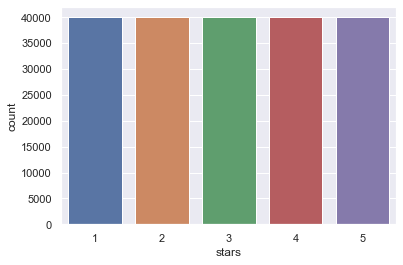

In [9]:
sns.countplot(df_train.stars)
plt.show()

Del gráfico anterior se desprende que las posibles calificaciones de los consumidores están perfectamente balanceadas.

Para el desarrollo de este proyecto trabajaremos con la librería `spaCy` y uno de sus modelos estadísticos pre entrenados.

Instanciamos dicho modelo.

In [10]:
nlp = es_core_news_lg.load()

### - Normalización

Notamos que en nuestro <i>dataset</i> hay <i>emojis</i>. Antes que nada, los quitaremos.

In [11]:
df_train['review_body'] = df_train['review_body'].str.replace('[^\w\s#@/:%.,_-]', '', flags = re.UNICODE)
df_train['review_title'] = df_train['review_title'].str.replace('[^\w\s#@/:%.,_-]', '',
                                                    flags = re.UNICODE)

Chequemos nuevamente si tenemos algún valor faltante en nuestras columnas.

In [12]:
df_train.isna().sum()

stars               0
review_body         0
review_title        0
product_category    0
dtype: int64

Ahora, vamos a normalizar los valores tanto de <i><b>review_body</b></i> como de <i><b>review_title</b></i>. Para ello, definiremos la siguiente función.

In [13]:
def normalize(comment, lowercase, remove_stopwords):
    punctuations = string.punctuation
    stops = spacy.lang.es.stop_words.STOP_WORDS
    non_stops = ['no', 'sí', 'si', 'bueno', 'buena', 'mal']
    otros = ['y', 'e', 'a', 'o', 'u', 'q', 'para', 'pare', 'paro', 'como', '..', '...',
             '....', '.....', '......', '.......', '........', '.........', '¡', '¿']
    letters = list(string.ascii_lowercase) + ['á', 'é', 'í', 'ó', 'ú', 'ü', 'ch', 'ñ']
    list_2 = []
    
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        if word.text not in non_stops:
            if not remove_stopwords or (remove_stopwords and word.text not in stops):
                if word.text not in punctuations:
                    if word.text not in otros:
                        lemma = word.lemma_.strip()
                        lemmatized.append(lemma)
        elif word.text in non_stops:
            lemma = word.lemma_.strip()
            lemmatized.append(lemma)
    for token in lemmatized:
        for ch in token:
            if ch not in letters:
                list_2.append(token)
    for w in list_2:
        if w in lemmatized:
            lemmatized.remove(w)                
    return " ".join(lemmatized)

Ahora, apliquemos esta función a las variables <i><b>review_body</b></i> y <i><b>review_title</b></i> y crearemos dos columnas adicionales en nuestro <i>DataFrame</i> con sus valores ya normalizados.

In [14]:
df_train['norm_body'] = df_train['review_body'].apply(normalize, lowercase = True,
                                          remove_stopwords = True)
df_train['norm_title'] = df_train['review_title'].apply(normalize, lowercase = True,
                                            remove_stopwords = True)
df_train.head()

,stars,review_body,review_title,product_category,norm_body,norm_title
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,electrónicos,bueno ka pantalla mesar no recibir respuesta f...,television nevir
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,electrónicos,horrible tener comprar inglés informático hora...,dinero tirar basura comprar
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,farmacia,obligar comprar unidad llegar no formar reclam...,llegar unidad obligar comprar
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,inalámbrico,no entrar descalificar vendedor mesar esperar ...,producto no recibir
4,1,Llega tarde y co la talla equivocada,Devuelto,zapatos,llegar co tallar equivocar,devolver


Verifiquemos nuevamente si no tenemos valores faltantes.

In [15]:
df_train.isna().sum()

stars               0
review_body         0
review_title        0
product_category    0
norm_body           0
norm_title          0
dtype: int64

Analicemos ahora nuestro <i>datset</i> en términos de la cantidad de estrellas de los registros.

Separaremos a las variables <i><b>review_body</b></i>, <i><b>review_title</b></i> y <i><b>product_category</b></i> de acuerdo a las estrellas que tienen.

In [16]:
review_body_1 = []
review_body_2 = []
review_body_3 = []
review_body_4 = []
review_body_5 = []

for i in range(df_train.shape[0]):
    if df_train.iloc[i].stars == 1:
        review_body_1.append(df_train.iloc[i].norm_body)
    elif df_train.iloc[i].stars == 2:
        review_body_2.append(df_train.iloc[i].norm_body)
    elif df_train.iloc[i].stars == 3:
        review_body_3.append(df_train.iloc[i].norm_body)
    elif df_train.iloc[i].stars == 4:
        review_body_4.append(df_train.iloc[i].norm_body)
    else:
        review_body_5.append(df_train.iloc[i].norm_body)

In [17]:
review_title_1 = []
review_title_2 = []
review_title_3 = []
review_title_4 = []
review_title_5 = []

for i in range(df_train.shape[0]):
    if df_train.iloc[i].stars == 1:
        review_title_1.append(df_train.iloc[i].norm_title)
    elif df_train.iloc[i].stars == 2:
        review_title_2.append(df_train.iloc[i].norm_title)
    elif df_train.iloc[i].stars == 3:
        review_title_3.append(df_train.iloc[i].norm_title)
    elif df_train.iloc[i].stars == 4:
        review_title_4.append(df_train.iloc[i].norm_title)
    else:
        review_title_5.append(df_train.iloc[i].norm_title)

In [18]:
product_1 = []
product_2 = []
product_3 = []
product_4 = []
product_5 = []

for i in range(df_train.shape[0]):
    if df_train.iloc[i].stars == 1:
        product_1.append(df_train.iloc[i].product_category)
    elif df_train.iloc[i].stars == 2:
        product_2.append(df_train.iloc[i].product_category)
    elif df_train.iloc[i].stars == 3:
        product_3.append(df_train.iloc[i].product_category)
    elif df_train.iloc[i].stars == 4:
        product_4.append(df_train.iloc[i].product_category)
    else:
        product_5.append(df_train.iloc[i].product_category)

Ahora, vamos a <i>tokenizar</i> los valores de las variables <i><b>review_body</b></i> y <i><b>review_title</b></i>.

In [19]:
review_1_words = []
review_2_words = []
review_3_words = []
review_4_words = []
review_5_words = []

for review in review_body_1:
    doc_1 = nlp(review)
    words_1 = [token.text for token in doc_1]
    review_1_words.append(words_1)
    
for review in review_body_2:
    doc_2 = nlp(review)
    words_2 = [token.text for token in doc_2]
    review_2_words.append(words_2)
    
for review in review_body_3:
    doc_3 = nlp(review)
    words_3 = [token.text for token in doc_3]
    review_3_words.append(words_3)
    
for review in review_body_4:
    doc_4 = nlp(review)
    words_4 = [token.text for token in doc_4]
    review_4_words.append(words_4)
    
for review in review_body_5:
    doc_5 = nlp(review)
    words_5 = [token.text for token in doc_5]
    review_5_words.append(words_5)

In [20]:
title_1_words = []
title_2_words = []
title_3_words = []
title_4_words = []
title_5_words = []

for title in review_title_1:
    doc_1_t = nlp(title)
    words_1_t = [token.text for token in doc_1_t]
    title_1_words.append(words_1_t)
    
for title in review_title_2:
    doc_2_t = nlp(title)
    words_2_t = [token.text for token in doc_2_t]
    title_2_words.append(words_2_t)
    
for title in review_title_3:
    doc_3_t = nlp(title)
    words_3_t = [token.text for token in doc_3_t]
    title_3_words.append(words_3_t)
    
for title in review_title_4:
    doc_4_t = nlp(title)
    words_4_t = [token.text for token in doc_4_t]
    title_4_words.append(words_4_t)
    
for title in review_title_5:
    doc_5_t = nlp(title)
    words_5_t = [token.text for token in doc_5_t]
    title_5_words.append(words_5_t)

Ya con los valores de estas variables <i>tokenizados</i>, veamos cuál es la frecuencia de palabras en ellas.

Pero antes, debemos de eliminar aquellos <i>tokens</i> que constan de números o carácteres que no son letras obien, que tienen estos números o carácteres en ellos. Para ello, definimos la siguiente función que aplicaremos a nuestras listas.

In [21]:
rev_1_words = list(itertools.chain(*review_1_words))
rev_2_words = list(itertools.chain(*review_2_words))
rev_3_words = list(itertools.chain(*review_3_words))
rev_4_words = list(itertools.chain(*review_4_words))
rev_5_words = list(itertools.chain(*review_5_words))

word_freq_body_1 = Counter(rev_1_words)
common_words_body_1 = word_freq_body_1.most_common(30)

word_freq_body_2 = Counter(rev_2_words)
common_words_body_2 = word_freq_body_2.most_common(30)

word_freq_body_3 = Counter(rev_3_words)
common_words_body_3 = word_freq_body_3.most_common(30)

word_freq_body_4 = Counter(rev_4_words)
common_words_body_4 = word_freq_body_4.most_common(30)

word_freq_body_5 = Counter(rev_5_words)
common_words_body_5 = word_freq_body_5.most_common(30)

In [22]:
def convert(tuples, dictionary):
    
    dictionary = dict(tuples)
    return dictionary

In [23]:
d_body_1 = {}
d_body_2 = {}
d_body_3 = {}
d_body_4 = {}
d_body_5 = {}

dict_body_1 = convert(common_words_body_1, d_body_1)
dict_body_2 = convert(common_words_body_2, d_body_2)
dict_body_3 = convert(common_words_body_3, d_body_3)
dict_body_4 = convert(common_words_body_4, d_body_4)
dict_body_5 = convert(common_words_body_5, d_body_5)

In [24]:
df_freq_body_1 = pd.DataFrame(list(dict_body_1.items()),
                              columns = ['Word', 'Frequency'])
df_freq_body_2 = pd.DataFrame(list(dict_body_2.items()),
                              columns = ['Word', 'Frequency'])
df_freq_body_3 = pd.DataFrame(list(dict_body_3.items()),
                              columns = ['Word', 'Frequency'])
df_freq_body_4 = pd.DataFrame(list(dict_body_4.items()),
                              columns = ['Word', 'Frequency'])
df_freq_body_5 = pd.DataFrame(list(dict_body_5.items()),
                              columns = ['Word', 'Frequency'])

In [25]:
def display_side_by_side(dfs: list, captions: list):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style = 'display: inline'").set_caption(caption)._repr_html_()
        output += '\xa0\xa0\xa0'
    display(HTML(output))

In [26]:
display_side_by_side([df_freq_body_1, df_freq_body_2, df_freq_body_3, df_freq_body_4,
                      df_freq_body_5],
                     ['Review Body, 1 star', 'Review Body, 2 stars', 'Review Body, 3 stars',
                      'Review Body, 4 stars', 'Review Body, 5 stars'])

,Word,Frequency
0,no,47673
1,comprar,7861
2,producto,7643
3,llegar,7579
4,funcionar,5614
5,si,4628
6,malo,4565
7,calidad,4300
8,devolver,4151
9,pedir,3836


In [27]:
title_words_1 = list(itertools.chain(*title_1_words))
title_words_2 = list(itertools.chain(*title_2_words))
title_words_3 = list(itertools.chain(*title_3_words))
title_words_4 = list(itertools.chain(*title_4_words))
title_words_5 = list(itertools.chain(*title_5_words))

word_freq_title_1 = Counter(title_words_1)
common_words_title_1 = word_freq_title_1.most_common(30)

word_freq_title_2 = Counter(title_words_2)
common_words_title_2 = word_freq_title_2.most_common(30)

word_freq_title_3 = Counter(title_words_3)
common_words_title_3 = word_freq_title_3.most_common(30)

word_freq_title_4 = Counter(title_words_4)
common_words_title_4 = word_freq_title_4.most_common(30)

word_freq_title_5 = Counter(title_words_5)
common_words_title_5 = word_freq_title_5.most_common(30)

In [28]:
d_title_1 = {}
d_title_2 = {}
d_title_3 = {}
d_title_4 = {}
d_title_5 = {}

dict_title_1 = convert(common_words_title_1, d_title_1)
dict_title_2 = convert(common_words_title_2, d_title_2)
dict_title_3 = convert(common_words_title_3, d_title_3)
dict_title_4 = convert(common_words_title_4, d_title_4)
dict_title_5 = convert(common_words_title_5, d_title_5)

In [29]:
df_freq_title_1 = pd.DataFrame(list(dict_title_1.items()),
                              columns = ['Word', 'Frequency'])
df_freq_title_2 = pd.DataFrame(list(dict_title_2.items()),
                              columns = ['Word', 'Frequency'])
df_freq_title_3 = pd.DataFrame(list(dict_title_3.items()),
                              columns = ['Word', 'Frequency'])
df_freq_title_4 = pd.DataFrame(list(dict_title_4.items()),
                              columns = ['Word', 'Frequency'])
df_freq_title_5 = pd.DataFrame(list(dict_title_5.items()),
                              columns = ['Word', 'Frequency'])

In [30]:
display_side_by_side([df_freq_title_1, df_freq_title_2, df_freq_title_3, df_freq_title_4,
                      df_freq_title_5],
                     ['Review Title, 1 star', 'Review Title, 2 stars',
                      'Review Title, 3 stars', 'Review Title, 4 stars',
                      'Review Title, 5 stars'])

,Word,Frequency
0,no,12668
1,malo,3849
2,calidad,2405
3,funcionar,1921
4,producto,1838
5,llegar,1803
6,mal,1700
7,comprar,1342
8,recibir,933
9,rotar,810


In [31]:
word_freq_product_1 = Counter(product_1)
common_words_product_1 = word_freq_product_1.most_common(30)

word_freq_product_2 = Counter(product_2)
common_words_product_2 = word_freq_product_2.most_common(30)

word_freq_product_3 = Counter(product_3)
common_words_product_3 = word_freq_product_3.most_common(30)

word_freq_product_4 = Counter(product_4)
common_words_product_4 = word_freq_product_4.most_common(30)

word_freq_product_5 = Counter(product_5)
common_words_product_5 = word_freq_product_5.most_common(30)

In [32]:
d_product_1 = {}
d_product_2 = {}
d_product_3 = {}
d_product_4 = {}
d_product_5 = {}

dict_product_1 = convert(common_words_product_1, d_product_1)
dict_product_2 = convert(common_words_product_2, d_product_2)
dict_product_3 = convert(common_words_product_3, d_product_3)
dict_product_4 = convert(common_words_product_4, d_product_4)
dict_product_5 = convert(common_words_product_5, d_product_5)

In [33]:
df_freq_product_1 = pd.DataFrame(list(dict_product_1.items()),
                              columns = ['Word', 'Frequency'])
df_freq_product_2 = pd.DataFrame(list(dict_product_2.items()),
                              columns = ['Word', 'Frequency'])
df_freq_product_3 = pd.DataFrame(list(dict_product_3.items()),
                              columns = ['Word', 'Frequency'])
df_freq_product_4 = pd.DataFrame(list(dict_product_4.items()),
                              columns = ['Word', 'Frequency'])
df_freq_product_5 = pd.DataFrame(list(dict_product_5.items()),
                              columns = ['Word', 'Frequency'])

In [34]:
display_side_by_side([df_freq_product_1, df_freq_product_2, df_freq_product_3,
                      df_freq_product_4, df_freq_product_5],
                     ['Product, 1 star', 'Product, 2 stars', 'Product, 3 stars',
                      'Product, 4 stars', 'Product, 5 stars'])

,Word,Frequency
0,inalámbrico,6283
1,hogar,5391
2,juguetes,2503
3,deportes,2438
4,electrónicos,2402
5,computación,2220
6,mejoras del hogar,2162
7,belleza,1546
8,automóbiles,1515
9,cocina,1322


Generemos gráficos para ver más fácilmente las frecuencias de las palabras.

Construyamos una función para ello.

In [35]:
def plot_frequencies(stars, df):
    
    plt.figure(figsize = (15,8))
    plot = sns.barplot(x  = df.iloc[:30].Word, y = df.iloc[:30].Frequency, palette = 'BrBG')
    for item in plot.get_xticklabels():
        item.set_rotation(90)
    plot.set_title(f'Frequency graph with {stars} stars')
    plt.show()

Comencemos graficando la frecuencia de palabras para <i><b>norm_body</b></i> por estrellas.

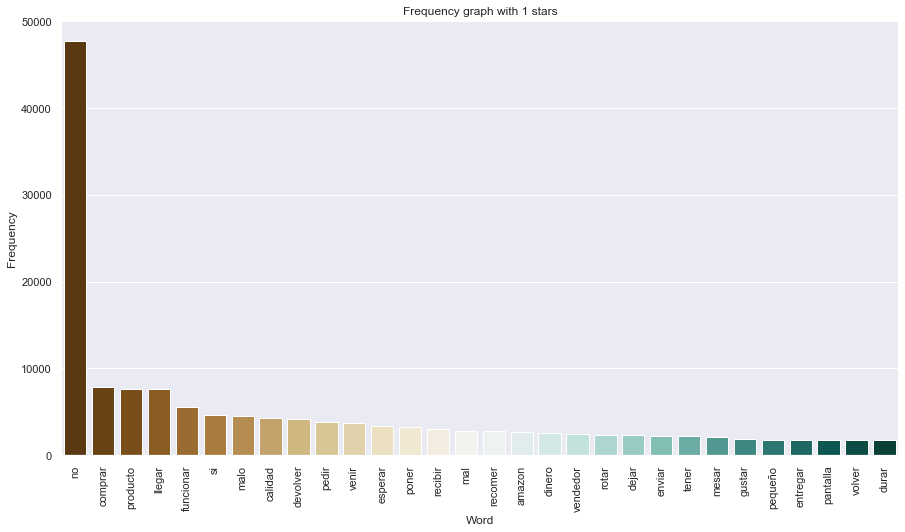

In [36]:
plot_frequencies(1, df_freq_body_1)

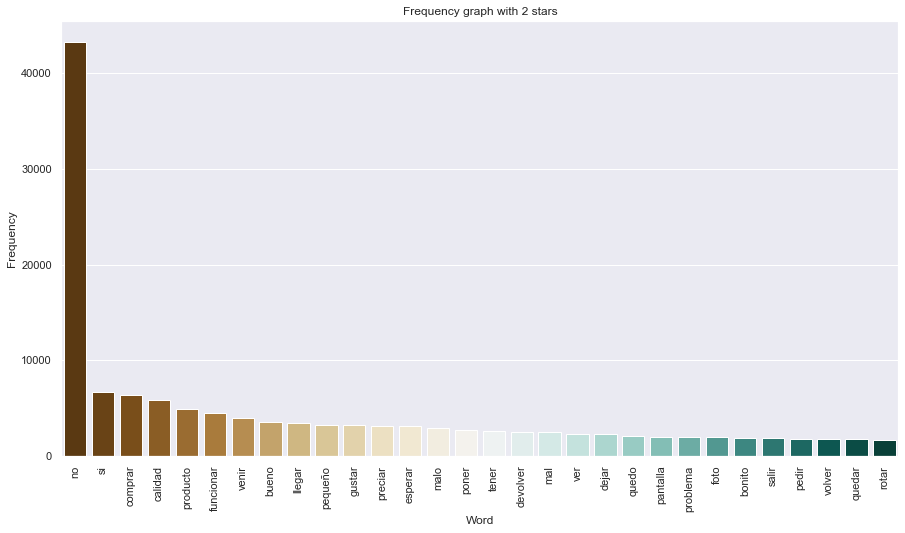

In [37]:
plot_frequencies(2, df_freq_body_2)

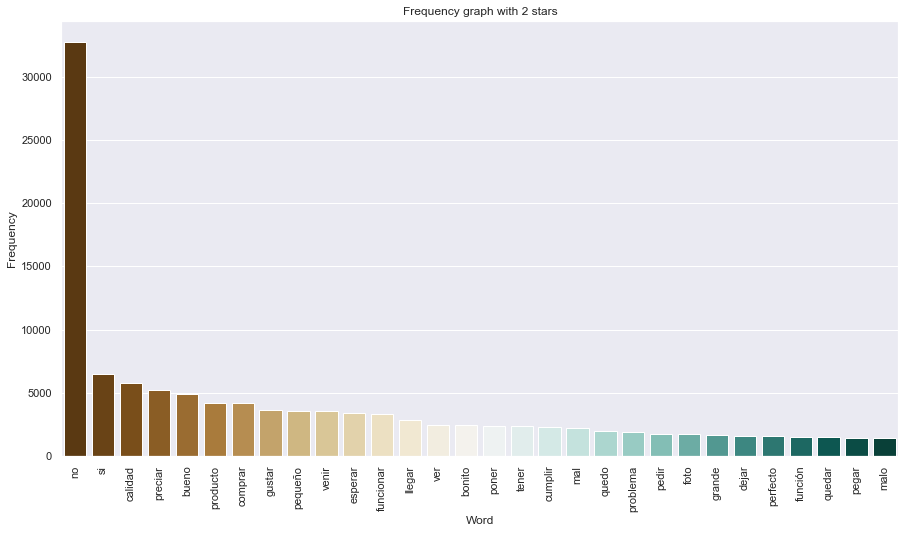

In [38]:
plot_frequencies(2, df_freq_body_3)

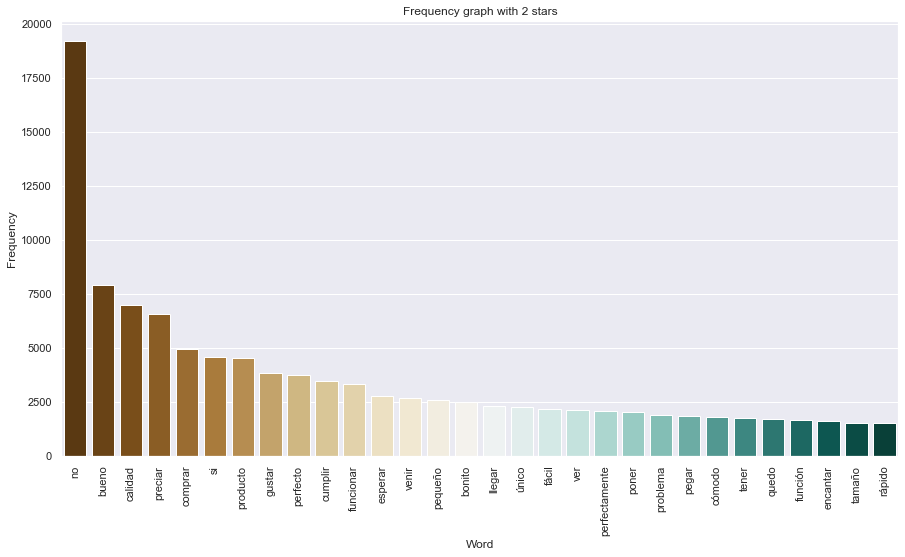

In [39]:
plot_frequencies(2, df_freq_body_4)

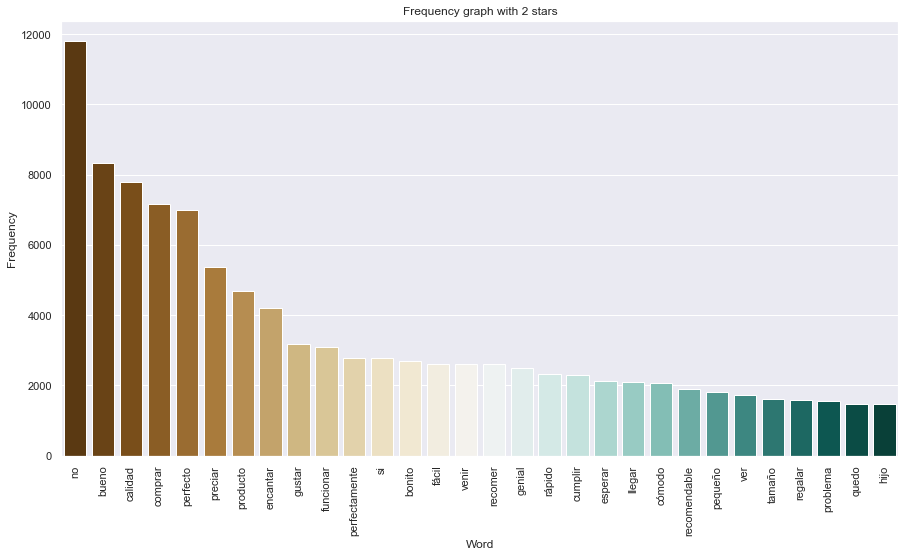

In [40]:
plot_frequencies(2, df_freq_body_5)

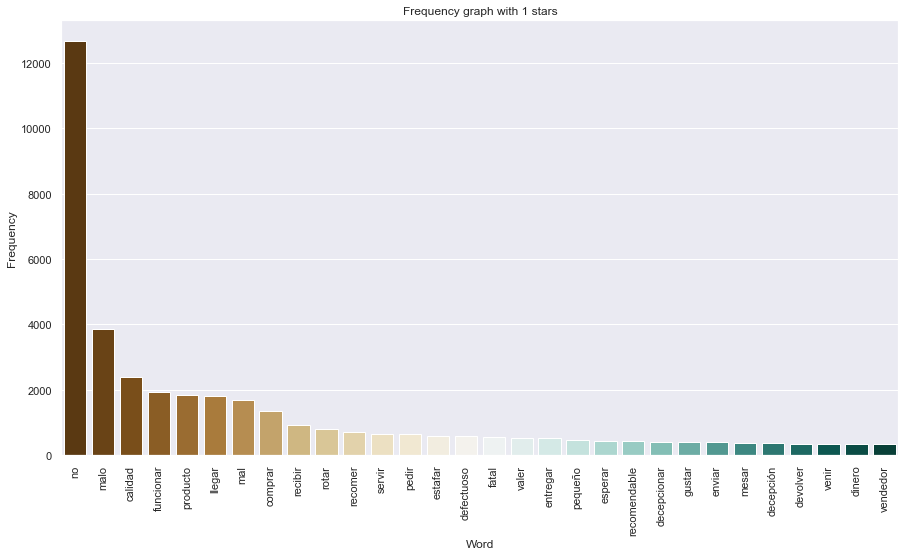

In [41]:
plot_frequencies(1, df_freq_title_1)

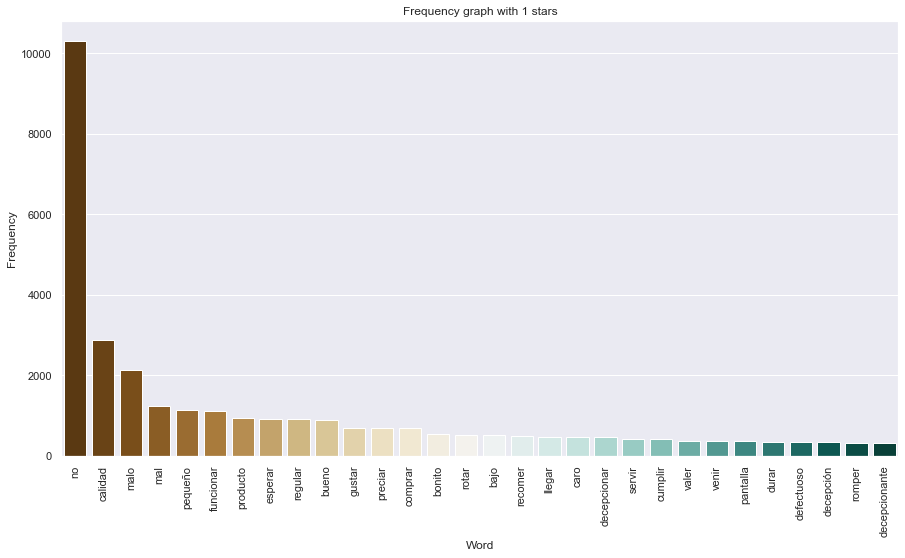

In [42]:
plot_frequencies(1, df_freq_title_2)

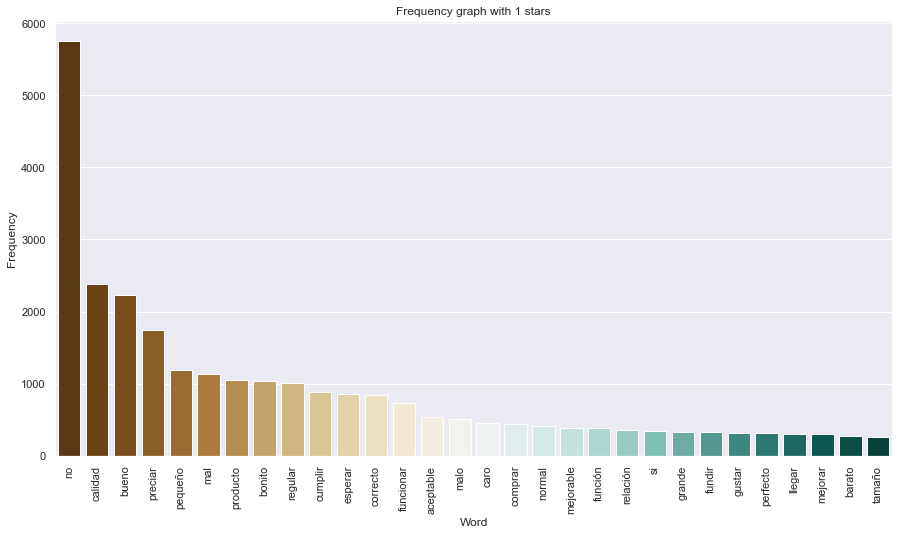

In [43]:
plot_frequencies(1, df_freq_title_3)

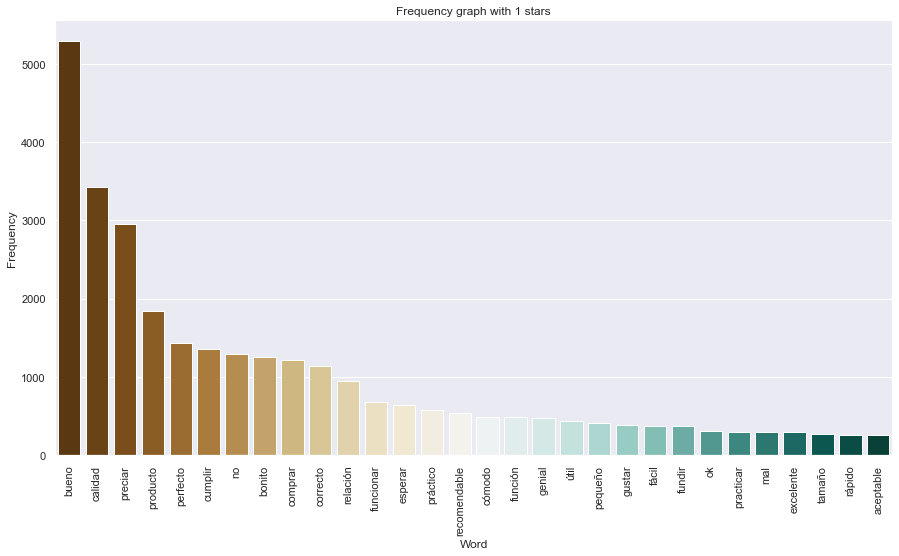

In [44]:
plot_frequencies(1, df_freq_title_4)

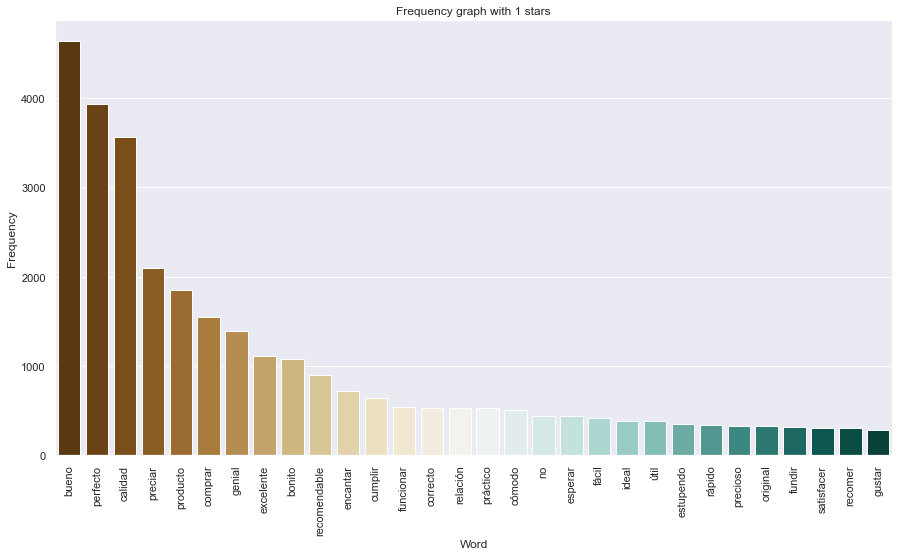

In [45]:
plot_frequencies(1, df_freq_title_5)

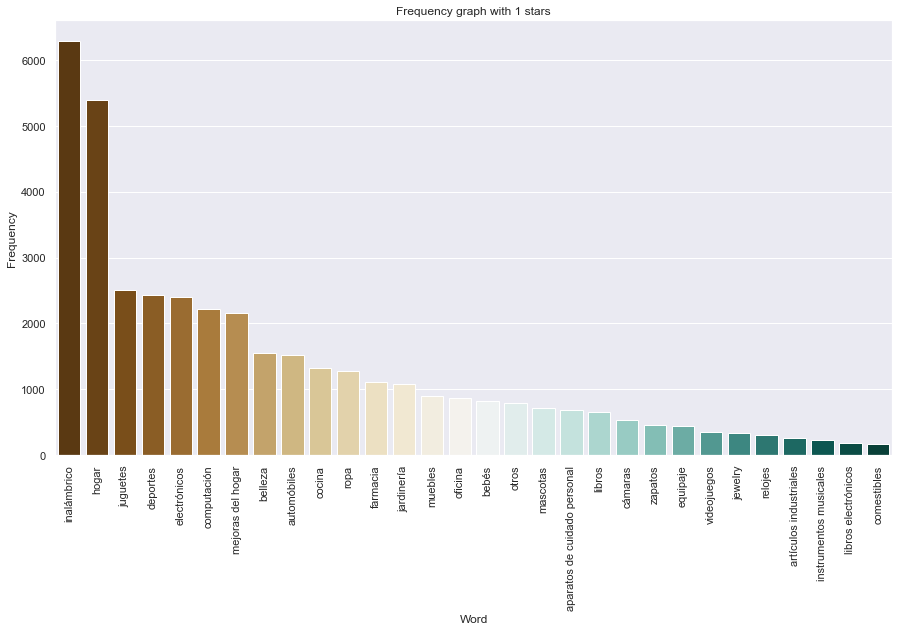

In [46]:
plot_frequencies(1, df_freq_product_1)

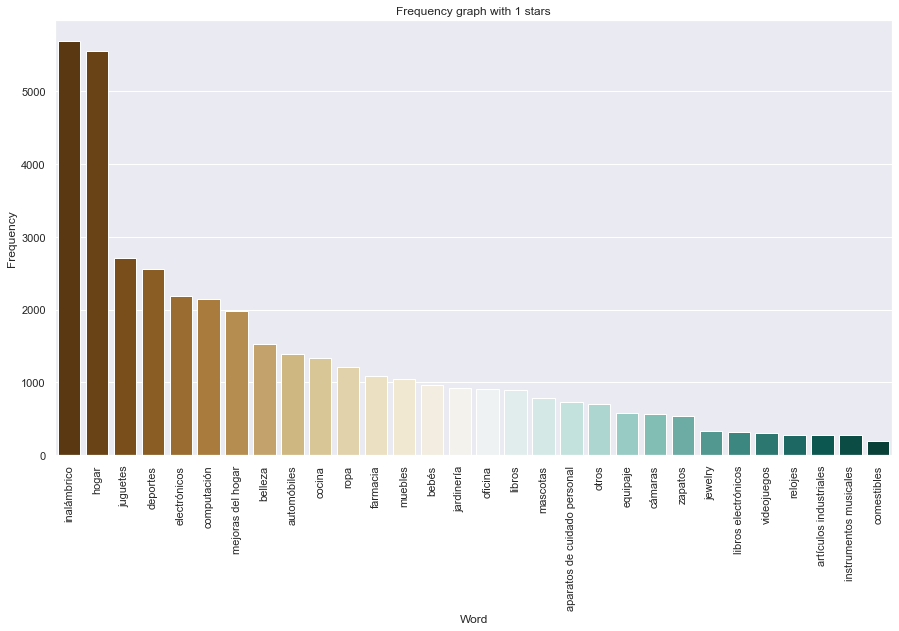

In [47]:
plot_frequencies(1, df_freq_product_2)

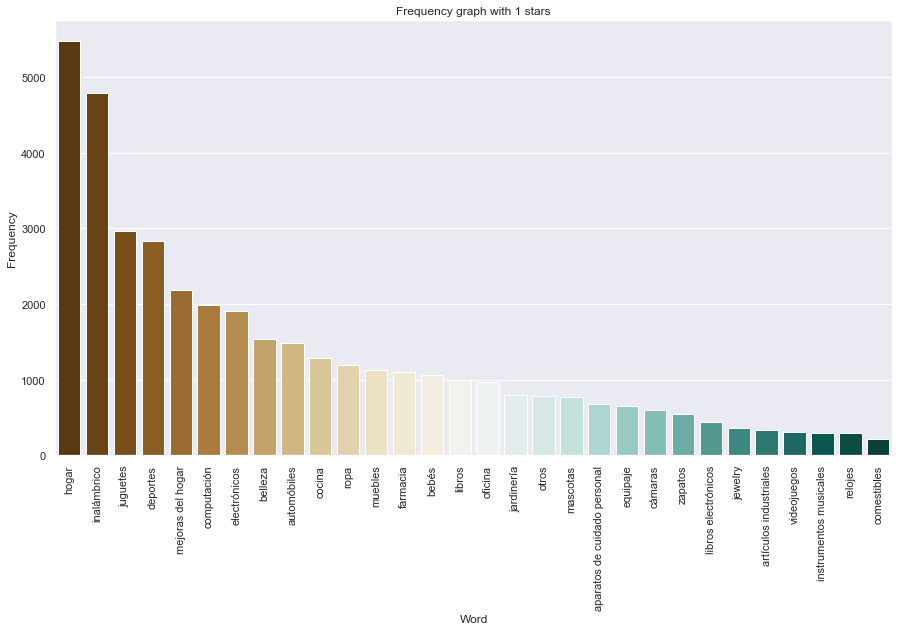

In [48]:
plot_frequencies(1, df_freq_product_3)

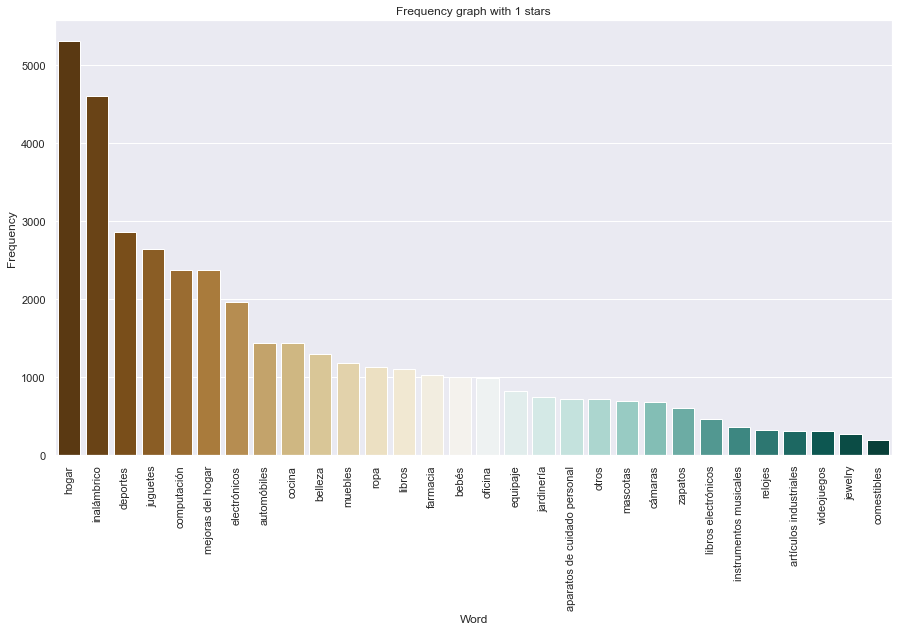

In [49]:
plot_frequencies(1, df_freq_product_4)

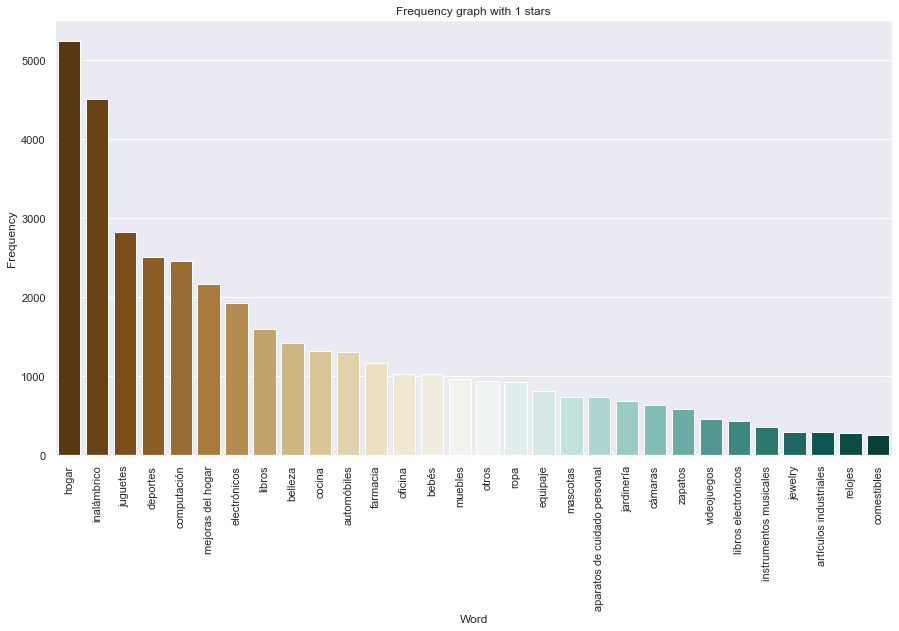

In [50]:
plot_frequencies(1, df_freq_product_5)

En ciertos contextos, puede ser útil identificar el objeto gramatical al que corresponden estas palabras. Veámoslo para las primeras diez de `norm_body` y `norm_title` con calificaciones de una y cinco estrellas, respectivamente.

In [51]:
keys_body_1 = []

for key in dict_body_1:
    keys_body_1.append(key)

j = 0

for w in keys_body_1:
    w_body_1 = nlp(w)
    for i in w_body_1:
        if j < 10:
            print(i, i.pos_)
            j += 1

no ADV
comprar VERB
producto NOUN
llegar VERB
funcionar VERB
si SCONJ
malo ADJ
calidad NOUN
devolver VERB
pedir VERB


In [52]:
keys_body_5 = []

for key in dict_body_5:
    keys_body_5.append(key)

j = 0

for w in keys_body_5:
    w_body_5 = nlp(w)
    for i in w_body_5:
        if j < 10:
            print(i, i.pos_)
            j += 1

no ADV
bueno INTJ
calidad NOUN
comprar VERB
perfecto ADJ
preciar VERB
producto NOUN
encantar VERB
gustar VERB
funcionar VERB


In [53]:
keys_title_1 = []

for key in dict_title_1:
    keys_title_1.append(key)

j = 0

for w in keys_title_1:
    w_title_1 = nlp(w)
    for i in w_title_1:
        if j < 10:
            print(i, i.pos_)
            j += 1

no ADV
malo ADJ
calidad NOUN
funcionar VERB
producto NOUN
llegar VERB
mal ADV
comprar VERB
recibir VERB
rotar VERB


In [54]:
keys_title_5 = []

for key in dict_title_5:
    keys_title_5.append(key)

v = 0

for w in keys_title_5:
    w_title_5 = nlp(w)
    for i in w_title_5:
        if v < 10:
            print(i, i.pos_)
            v += 1

bueno INTJ
perfecto ADJ
calidad NOUN
preciar VERB
producto NOUN
comprar VERB
genial ADJ
excelente ADJ
bonito ADJ
recomendable ADJ


### - Conclusiones

1. Es destacable que en el cuerpo de reseñas, <i><b>Amazon</b></i> aparece sólo en aquellas con una estrella. Esto sugiere que al usuario le interesa exhibir a la empresa cuando está insatisfecho con su producto mas no reconocerla cuando está satisfecho.
1. Se decidió exclur de las <i>stop words</i> a <i><b>no</b></i>, <i><b>si</b></i> y <i><b>sí</b></i> por considerarse que pueden alterar completamente el sentido de un comentario. En el cuerpo de reseñas <i><b>no</b></i> aparece siempre como la más frecuente por lo que así, fuera de contexto, no parece tener correlación con comentarios negativos de los consumidores. Sin embargo, en los títulos de las reseñas sí parece correlacionarse con la satisfacción de los consumidores. La palabra <i><b>si</b></i>, que sabemos es condicional aunque muchas veces se usa como <i><b>sí</b></i>, el adverbio afirmativo, parece estar casi negativamente correlacionado con la satisfacción del consumidor.
1. A juzgar por la frecuencia de <i><b>llegar</b></i> en el cuerpo de las reseñas, muchas de las quejas de los consumidores se deben a incumplimiento con los tiempos de entrega estipulados.
1. En cuanto a los productos, dado que <i><b>Inalámbricos</b></i>, <i><b>hogar</b></i> y <i><b>juguetes</b></i> siempre están en las primeras cuatro palabras con más frecuencia, se desprende que estos son los productos más solicitados por los consumidores mientras que <i><b>comestibles</b></i> es el producto menos solicitado de entre los primeros treinta.

In [55]:
gc.collect()

68415

### - <i>Dataset Dev</i>

Trabajeremos ahora el <i>dataset</i> de <i>dev</i>. Haremos sólo un breve análisis exploratorio de datos para verificar que no se tenga alguna inconsistencia. Carguémoslo.

In [56]:
dataset_dev = pd.read_json('dataset_es_dev.json', lines = True)
dataset_dev.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless
4999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel


Como en el de <i>train</i>, traduciremos al español los valores de la variable <i><b>product_category</b></i> y eliminaremos las variables que no son relevantes.

In [57]:
dataset_dev.product_category.unique()

array(['wireless', 'apparel', 'sports', 'home_improvement', 'beauty',
       'home', 'baby_product', 'pc', 'toy', 'book',
       'personal_care_appliances', 'kitchen', 'lawn_and_garden',
       'pet_products', 'drugstore', 'office_product', 'furniture',
       'electronics', 'automotive', 'shoes', 'jewelry', 'luggage',
       'camera', 'industrial_supplies', 'other', 'musical_instruments',
       'grocery', 'digital_ebook_purchase', 'video_games', 'watch'],
      dtype=object)

In [58]:
dataset_dev_esp = dataset_dev.copy()
dataset_dev_esp['product_category'].replace(dictionary, inplace = True)

In [59]:
df_dev = dataset_dev_esp.drop(['review_id', 'product_id', 'reviewer_id', 'language'], axis = 1)

Verifiquemos ahora si tenemos valores faltantes en este conjunto de datos y vemos la distribución de las estrellas.

In [60]:
df_dev.isna().sum()

stars               0
review_body         0
review_title        0
product_category    0
dtype: int64

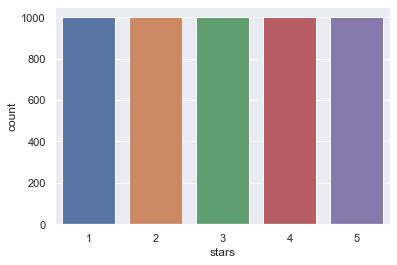

In [61]:
sns.countplot(df_dev.stars)
plt.show()

A continuación, quitamos los <i>emojis</i> que haya en los valores de las variables <i><b>review_body</b></i> y <b>review_title</b></i> y agegamos estas columnas ya normalizadas, <b>norm_body</b> y <b>norm_title</b></i>, al <i>DataFrame</i>.

In [62]:
df_dev['review_body'] = df_dev['review_body'].str.replace('[^\w\s#@/:%.,_-]', '',
                                                    flags = re.UNICODE)
df_dev['review_title'] = df_dev['review_title'].str.replace('[^\w\s#@/:%.,_-]', '',
                                                    flags = re.UNICODE)

In [63]:
df_dev['norm_body'] = df_dev['review_body'].apply(normalize, lowercase = True,
                                          remove_stopwords = True)
df_dev['norm_title'] = df_dev['review_title'].apply(normalize, lowercase = True,
                                            remove_stopwords = True)

Verifiquemos nuevamente si no tenemos valores faltantes.

In [64]:
df_dev.isna().sum()

stars               0
review_body         0
review_title        0
product_category    0
norm_body           0
norm_title          0
dtype: int64

### - <i>Dataset Test</i>.

Trabajeremos ahora el <i>dataset</i> de <i>test</i>. Haremos sólo un breve análisis exploratorio de datos para verificar que no se tenga alguna inconsistencia. Carguémoslo.

In [65]:
dataset_test = pd.read_json('dataset_es_test.json', lines = True)
dataset_test.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
4995,es_0685611,product_es_0919143,reviewer_es_0461769,5,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,es,wireless
4996,es_0638242,product_es_0636134,reviewer_es_0214562,5,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",es,wireless
4997,es_0760108,product_es_0078583,reviewer_es_0043609,5,Se ve bien el grabado,medallas con bonito grabado,es,home
4998,es_0070806,product_es_0359350,reviewer_es_0258717,5,lo compré para mi bici pero finalmente se lo h...,timbre,es,sports
4999,es_0794544,product_es_0130307,reviewer_es_0651938,5,Pues este tipo de cascos si que son inalambric...,Auriculares sin cables de verdad,es,electronics


Como en el de <i>train</i> y <i>dev</i>, traduciremos al español los valores de la variable <i><b>product_category</b></i> y eliminaremos las variables que no son relevantes.

In [66]:
dataset_test.product_category.unique()

array(['wireless', 'home', 'toy', 'digital_ebook_purchase', 'pc',
       'lawn_and_garden', 'sports', 'camera', 'home_improvement',
       'apparel', 'automotive', 'drugstore', 'electronics', 'other',
       'beauty', 'office_product', 'furniture', 'kitchen', 'shoes',
       'video_games', 'personal_care_appliances', 'pet_products', 'book',
       'jewelry', 'watch', 'luggage', 'baby_product',
       'industrial_supplies', 'musical_instruments', 'grocery'],
      dtype=object)

In [67]:
dataset_test_esp = dataset_test.copy()
dataset_test_esp['product_category'].replace(dictionary, inplace = True)

In [68]:
df_test = dataset_test_esp.drop(['review_id', 'product_id', 'reviewer_id', 'language'],
                                axis = 1)

Verifiquemos ahora si tenemos valores faltantes en este conjunto de datos y vemos la distribución de las estrellas.

In [69]:
df_test.isna().sum()

stars               0
review_body         0
review_title        0
product_category    0
dtype: int64

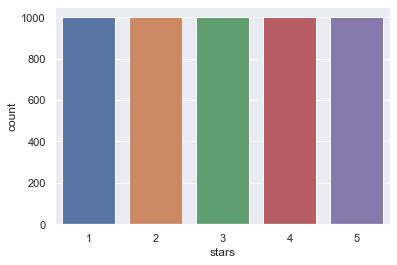

In [70]:
sns.countplot(df_test.stars)
plt.show()

A continuación, quitamos los <i>emojis</i> que haya en los valores de las variables <i><b>review_body</b></i> y <b>review_title</b></i> y agegamos estas columnas ya normalizadas, <b>norm_body</b> y <b>norm_title</b></i>, al <i>DataFrame</i>.

In [71]:
df_test['review_body'] = df_test['review_body'].str.replace('[^\w\s#@/:%.,_-]', '',
                                                    flags = re.UNICODE)
df_test['review_title'] = df_test['review_title'].str.replace('[^\w\s#@/:%.,_-]', '',
                                                    flags = re.UNICODE)

In [72]:
df_test['norm_body'] = df_test['review_body'].apply(normalize, lowercase = True,
                                          remove_stopwords = True)
df_test['norm_title'] = df_test['review_title'].apply(normalize, lowercase = True,
                                            remove_stopwords = True)

Verifiquemos nuevamente si no tenemos valores faltantes.

In [73]:
df_test.isna().sum()

stars               0
review_body         0
review_title        0
product_category    0
norm_body           0
norm_title          0
dtype: int64

In [74]:
gc.collect()

4859

## Parte B - Modelos de Machine Learning

Consideraremos tres variables: las variables `norm_body` y `norm_title` y una con todas las oraciones de `norm_body` y `norm_title` en una sola, variable a la que llamaremos `norm_review_titles`.

Queremos ver cómo predicen nuestros modelos con cada una de ellas.

Creamos un <i>DataFrame</i> de <i>Train</i> con nuestra nueva variable `norm_review_titles`.

In [75]:
df_train_unif = df_train.copy()
df_train_unif['norm_reviews_titles'] = df_train_unif['norm_body'] + ' ' + df_train_unif['norm_title']
df_train_unif.tail()

,stars,review_body,review_title,product_category,norm_body,norm_title,norm_reviews_titles
199995,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,electrónicos,mandar funcionar perfectamente cumplir funcion...,describir,mandar funcionar perfectamente cumplir funcion...
199996,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,electrónicos,comprar batería reticencia resultar fácil inst...,funcionar perfectamente,comprar batería reticencia resultar fácil inst...
199997,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,ropa,bueno calidad satisfacer comprar,bueno calidad,bueno calidad satisfacer comprar bueno calidad
199998,5,Perfecto para el cumple de mi hijo,Recomendado,juguetes,perfecto cumplir hijo,recomendar,perfecto cumplir hijo recomendar
199999,5,"Súper bien Las brochas son buenas, no sé menos...",Preciosas,hogar,súper brocha no caer pelitos pesar chulo xd,precioso,súper brocha no caer pelitos pesar chulo xd pr...


De la misma forma que arriba, creamos un <i>DataFrame</i> de <i>Dev</i> y uno de <i>Test</i> con nuestra nueva variable `norm_review_titles`.

In [76]:
df_dev_unif = df_dev.copy()
df_dev_unif['norm_reviews_titles'] = df_dev_unif['norm_body'] + ' ' + df_dev_unif['norm_title']

In [77]:
df_test_unif = df_test.copy()
df_test_unif['norm_reviews_titles'] = df_test_unif['norm_body'] + ' ' + df_test_unif['norm_title']

### - Modelo <i>benchmark</i>

A continiuación definiremos nuestro modelo <i>benchmark</i>. Este será un modelo `GaussianNB` con sus valores por defecto.

In [78]:
nb = GaussianNB()

# Convertimos en lista los valores de las columnas 'norm_reviews_titles' de ambos datasets.
list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)
list_rev_titles_the_test = list(df_test_unif['norm_reviews_titles'].values)

# Vectorizamos los features de la variable de entrenamiento y definimos tanto el número de
# estos que consideraremos como nuestros conjuntos de entrenamiento.
vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 10000)
vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
X_train = vect_rev_titles_train.toarray()
y_train = df_train_unif['stars'].values

# Entrenamos al modelo.
nb.fit(X_train, y_train)

# Vectorizamos los features de la variable objetivo y definimos los conjutnos de prueba.
vect_rev_titles_the_test = vectorizer.transform(list_rev_titles_the_test)
X_test = vect_rev_titles_the_test.toarray()
y_test = df_test_unif['stars'].values

# Predecimos los valores de los conjuntos X_train y X_test.
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

# Imprimimos los accuracys.
print('Train accuracy:', accuracy_score(y_train, y_train_pred))
print('Test accuracy:', accuracy_score(y_test, y_test_pred))

Train accuracy: 0.445115
Test accuracy: 0.4076


Definimos ahora la función que usaremos para llamar a la matriz de confusión y la usamos.

In [79]:
def confusion_5(ytest, y_pred):
    names = ['One Star', 'Two Stars', 'Three Stars', 'Four Stars', 'Five Stars']
    cm = confusion_matrix(ytest, y_pred)
    f, ax = plt.subplots(figsize = (5, 5))
    sns.heatmap(cm, annot = True, linewidth = .5, linecolor = "r", fmt = ".0f", ax = ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names, rotation = 45)
    ax.set_yticklabels(names, rotation = 45)
    plt.show()

    return

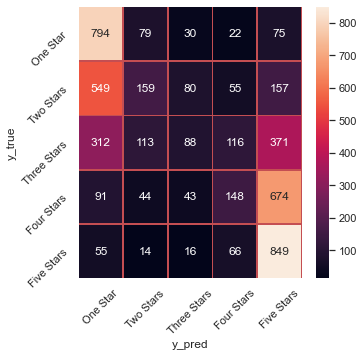

In [80]:
confusion_5(y_test, y_test_pred)

De la matriz de confusión se sigue que las estrellas 1 y 5 fueron las mejor predichas por el modelo.

Ahora sí, ya con nuestro modelo <i>benchmark</i> definido y probado procedemos a encontrar el número adecuado de <i>features</i> para nuestros modelos<sup>(1)</sup>.

En este proceso, se probaron rangos muy amplios y fueron reduciéndose conforme se veía alrededor de qué número de <i>features</i> era mejor el <i>accuracy</i> del modelo. Con la idea de no hacer tedioso e innecesariamente largo este proyecto, se deja únicamente el último código que se corrió con el cual nos quedamos con el número de <i>features</i> que se utilizarán para alimentar el modelo.

**(1):** Para decidir qué modelos se implementarían para este proyecto, se probaron varios con sus valores por defecto, entre ellos, además de los elegidos, `RandomForest`, `XGboost` y `KnnNeighbours`. Finalmente, nos quedamos con aquellos dos que arroajaron un mejor resultado.

In [81]:
# Convertimos en lista los valores de las columnas 'norm_reviews_titles' de ambos datasets.
list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)
list_rev_titles_test = list(df_dev_unif['norm_reviews_titles'].values)

# Definimos dos listas vacías que guardarán los accuracys de train y test.
acc_rev_titles_train = []
acc_rev_titles_test = []

# Definimmos la lista con los números de features que probaremos.
num_max_features = [1900, 2000, 2100]

# Probamos los distintos valores.
for i in num_max_features:
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = i)
    vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
    vect_rev_titles_test = vectorizer.transform(list_rev_titles_test)
    X_train = vect_rev_titles_train.toarray()
    y_train = df_train_unif['stars'].values
    X_test = vect_rev_titles_test.toarray()
    y_test = df_dev_unif['stars'].values
    
    # Definimos el modelo a probar y lo entrenamos.
    svc = LinearSVC(dual = False, random_state = 42)
    svc.fit(X_train, y_train)
    
    # Obtenemos los valores predichos para train.
    y_pred_rev_titles_train = svc.predict(X_train)
    accuracy_rev_titles_train = accuracy_score(y_train, y_pred_rev_titles_train)
    
    # Obtenemos los valores predichos para test.
    y_pred_rev_titles_test = svc.predict(X_test)
    accuracy_rev_titles_test = accuracy_score(y_test, y_pred_rev_titles_test)
    
    # Copiamos los accuracys en nuestras listas.
    acc_rev_titles_train.append(accuracy_rev_titles_train)
    acc_rev_titles_test.append(accuracy_rev_titles_test)

Text(0, 0.5, 'Accuracy')

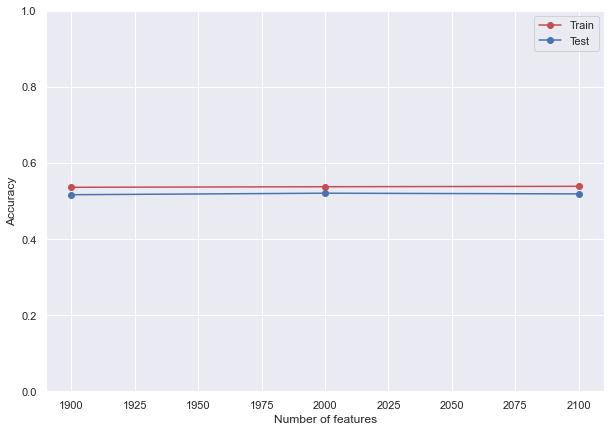

In [82]:
plt.figure(figsize = (10, 7))
plt.plot(num_max_features, acc_rev_titles_train, 'o-', label = 'Train', color = 'r')
plt.plot(num_max_features, acc_rev_titles_test, 'o-', label = 'Test', color = 'b')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Accuracy')

In [83]:
print(acc_rev_titles_train)
print(acc_rev_titles_test)

[0.53611, 0.53759, 0.538675]
[0.5166, 0.5206, 0.5188]


Ahora, hagamos lo propio con nuestra próxima variable a probar, `norm_body`.

In [84]:
# Convertimos en lista los valores de las columnas 'norm_reviews_titles' de ambos datasets.
list_rev_train = list(df_train_unif['norm_body'].values)
list_rev_test = list(df_dev_unif['norm_body'].values)

# Definimos dos listas vacías que guardarán los accuracys de train y test.
acc_rev_train = []
acc_rev_test = []

# Definimmos la lista con los números de features que probaremos.
num_max_features = [4900, 5000, 5100]

# Probamos los distintos valores.
for i in num_max_features:
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = i)
    vect_rev_train = vectorizer.fit_transform(list_rev_train)
    vect_rev_test = vectorizer.transform(list_rev_test)
    X_train = vect_rev_train.toarray()
    y_train = df_train_unif['stars'].values
    X_test = vect_rev_test.toarray()
    y_test = df_dev_unif['stars'].values
    
    # Definimos el modelo a probar y lo entrenamos.
    svc = LinearSVC(dual = False, random_state = 42)
    svc.fit(X_train, y_train)
    
    # Obtenemos los valores predichos para train.
    y_pred_rev_train = svc.predict(X_train)
    accuracy_rev_train = accuracy_score(y_train, y_pred_rev_train)
    
    # Obtenemos los valores predichos para test.
    y_pred_rev_test = svc.predict(X_test)
    accuracy_rev_test = accuracy_score(y_test, y_pred_rev_test)
    
    # Copiamos los accuracys en nuestras listas.
    acc_rev_train.append(accuracy_rev_train)
    acc_rev_test.append(accuracy_rev_test)

Text(0, 0.5, 'Accuracy')

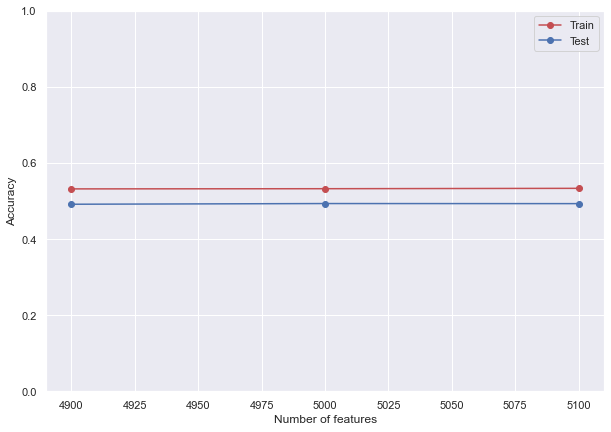

In [85]:
plt.figure(figsize = (10, 7))
plt.plot(num_max_features, acc_rev_train, 'o-', label = 'Train', color = 'r')
plt.plot(num_max_features, acc_rev_test, 'o-', label = 'Test', color = 'b')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Accuracy')

In [86]:
print(acc_rev_train)
print(acc_rev_test)

[0.531925, 0.532415, 0.53339]
[0.4916, 0.4934, 0.4932]


Finalmente, nuestra última variable, `norm_title`.

In [87]:
# Convertimos en lista los valores de las columnas 'norm_reviews_titles' de ambos datasets.
list_titles_train = list(df_train_unif['norm_title'].values)
list_titles_test = list(df_dev_unif['norm_title'].values)

# Definimos dos listas vacías que guardarán los accuracys de train y test.
acc_titles_train = []
acc_titles_test = []

# Definimmos la lista con los números de features que probaremos.
num_max_features = [3000, 5000, 7500, 10000]

# Probamos los distintos valores.
for i in num_max_features:
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = i)
    vect_titles_train = vectorizer.fit_transform(list_titles_train)
    vect_titles_test = vectorizer.transform(list_titles_test)
    X_train = vect_titles_train.toarray()
    y_train = df_train_unif['stars'].values
    X_test = vect_titles_test.toarray()
    y_test = df_dev_unif['stars'].values
    
    # Definimos el modelo a probar y lo entrenamos.
    svc = LinearSVC(dual = False, random_state = 42)
    svc.fit(X_train, y_train)
    
    # Obtenemos los valores predichos para train.
    y_pred_titles_train = svc.predict(X_train)
    accuracy_titles_train = accuracy_score(y_train, y_pred_titles_train)
    
    # Obtenemos los valores predichos para test.
    y_pred_titles_test = svc.predict(X_test)
    accuracy_titles_test = accuracy_score(y_test, y_pred_titles_test)
    
    # Copiamos los accuracys en nuestras listas.
    acc_titles_train.append(accuracy_titles_train)
    acc_titles_test.append(accuracy_titles_test)

Text(0, 0.5, 'Accuracy')

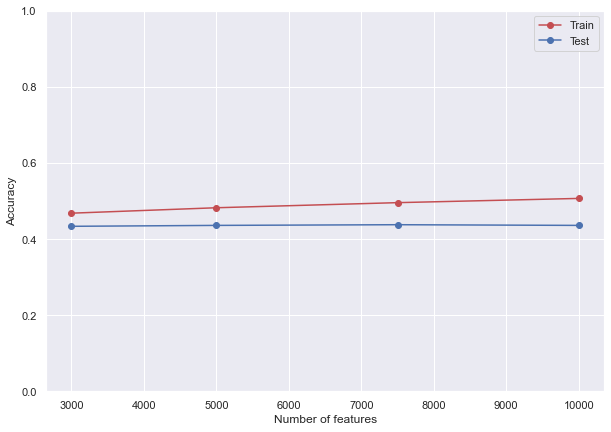

In [88]:
plt.figure(figsize = (10, 7))
plt.plot(num_max_features, acc_titles_train, 'o-', label = 'Train', color = 'r')
plt.plot(num_max_features, acc_titles_test, 'o-', label = 'Test', color = 'b')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Accuracy')

In [89]:
print(acc_titles_train)
print(acc_titles_test)

[0.4681, 0.48237, 0.495765, 0.50688]
[0.4336, 0.436, 0.4378, 0.436]


De lo anterior se desprende que para nuestro primer modelo a estudiar, `LinearSVC`, nuestra mejor variable predictora es `norm_reviews_titles` y el mejor número de <i>features</i> es de **2,000**.

Ahora, estudiemos nuestro siguiente modelo, `LogisticRegression`, a la luz del mismo análisis que antes.

In [90]:
# Convertimos en lista los valores de las columnas 'norm_reviews_titles' de ambos datasets.
list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)
list_rev_titles_test = list(df_dev_unif['norm_reviews_titles'].values)

# Definimos dos listas vacías que guardarán los accuracys de train y test.
acc_rev_titles_train = []
acc_rev_titles_test = []

# Definimmos la lista con los números de features que probaremos.
num_max_features = [2000, 2500, 3000]

# Probamos los distintos valores.
for i in num_max_features:
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = i)
    vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
    vect_rev_titles_test = vectorizer.transform(list_rev_titles_test)
    X_train = vect_rev_titles_train.toarray()
    y_train = df_train_unif['stars'].values
    X_test = vect_rev_titles_test.toarray()
    y_test = df_dev_unif['stars'].values
    
    # Definimos el modelo a probar y lo entrenamos.
    lr = LogisticRegression(dual = False, penalty = 'elasticnet', solver = 'saga',
                            l1_ratio = .5, random_state = 42)
    lr.fit(X_train, y_train)
    
    # Obtenemos los valores predichos para train.
    y_pred_rev_titles_train = lr.predict(X_train)
    accuracy_rev_titles_train = accuracy_score(y_train, y_pred_rev_titles_train)
    
    # Obtenemos los valores predichos para test.
    y_pred_rev_titles_test = lr.predict(X_test)
    accuracy_rev_titles_test = accuracy_score(y_test, y_pred_rev_titles_test)
    
    # Copiamos los accuracys en nuestras listas.
    acc_rev_titles_train.append(accuracy_rev_titles_train)
    acc_rev_titles_test.append(accuracy_rev_titles_test)

Text(0, 0.5, 'Accuracy')

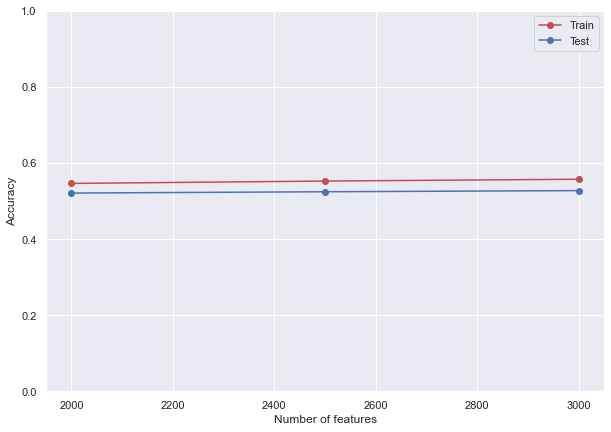

In [91]:
plt.figure(figsize = (10, 7))
plt.plot(num_max_features, acc_rev_titles_train, 'o-', label = 'Train', color = 'r')
plt.plot(num_max_features, acc_rev_titles_test, 'o-', label = 'Test', color = 'b')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Accuracy')

In [92]:
print(acc_rev_titles_train)
print(acc_rev_titles_test)

[0.54631, 0.55252, 0.55727]
[0.521, 0.5244, 0.5274]


Ahora, hagamos lo propio con nuestra próxima variable a probar, `norm_body`.

In [93]:
# Convertimos en lista los valores de las columnas 'norm_reviews_titles' de ambos datasets.
list_rev_train = list(df_train_unif['norm_body'].values)
list_rev_test = list(df_dev_unif['norm_body'].values)

# Definimos dos listas vacías que guardarán los accuracys de train y test.
acc_rev_train = []
acc_rev_test = []

# Definimmos la lista con los números de features que probaremos.
num_max_features = [4000, 5000, 6000]

# Probamos los distintos valores.
for i in num_max_features:
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = i)
    vect_rev_train = vectorizer.fit_transform(list_rev_train)
    vect_rev_test = vectorizer.transform(list_rev_test)
    X_train = vect_rev_train.toarray()
    y_train = df_train_unif['stars'].values
    X_test = vect_rev_test.toarray()
    y_test = df_dev_unif['stars'].values
    
    # Definimos el modelo a probar y lo entrenamos.
    lr = LogisticRegression(dual = False, penalty = 'elasticnet', solver = 'saga',
                            l1_ratio = .5, random_state = 42)
    lr.fit(X_train, y_train)
    
    # Obtenemos los valores predichos para train.
    y_pred_rev_train = lr.predict(X_train)
    accuracy_rev_train = accuracy_score(y_train, y_pred_rev_train)
    
    # Obtenemos los valores predichos para test.
    y_pred_rev_test = lr.predict(X_test)
    accuracy_rev_test = accuracy_score(y_test, y_pred_rev_test)
    
    # Copiamos los accuracys en nuestras listas.
    acc_rev_train.append(accuracy_rev_train)
    acc_rev_test.append(accuracy_rev_test)

Text(0, 0.5, 'Accuracy')

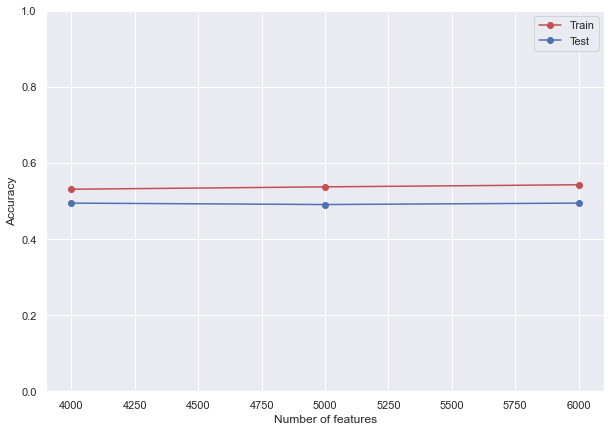

In [94]:
plt.figure(figsize = (10, 7))
plt.plot(num_max_features, acc_rev_train, 'o-', label = 'Train', color = 'r')
plt.plot(num_max_features, acc_rev_test, 'o-', label = 'Test', color = 'b')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Accuracy')

In [95]:
print(acc_rev_train)
print(acc_rev_test)

[0.531025, 0.53729, 0.54278]
[0.4946, 0.4908, 0.4946]


Finalmente, nuestra última variable, `norm_title`.

In [96]:
# Convertimos en lista los valores de las columnas 'norm_reviews_titles' de ambos datasets.
list_titles_train = list(df_train_unif['norm_title'].values)
list_titles_test = list(df_dev_unif['norm_title'].values)

# Definimos dos listas vacías que guardarán los accuracys de train y test.
acc_titles_train = []
acc_titles_test = []

# Definimmos la lista con los números de features que probaremos.
num_max_features = [500, 1000, 2000, 5000, 10000]

# Probamos los distintos valores.
for i in num_max_features:
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = i)
    vect_titles_train = vectorizer.fit_transform(list_titles_train)
    vect_titles_test = vectorizer.transform(list_titles_test)
    X_train = vect_titles_train.toarray()
    y_train = df_train_unif['stars'].values
    X_test = vect_titles_test.toarray()
    y_test = df_dev_unif['stars'].values
    
    # Definimos el modelo a probar y lo entrenamos.
    lr = LogisticRegression(dual = False, penalty = 'elasticnet', solver = 'saga',
                            l1_ratio = .5, random_state = 42)
    lr.fit(X_train, y_train)
    
    # Obtenemos los valores predichos para train.
    y_pred_titles_train = lr.predict(X_train)
    accuracy_titles_train = accuracy_score(y_train, y_pred_titles_train)
    
    # Obtenemos los valores predichos para test.
    y_pred_titles_test = lr.predict(X_test)
    accuracy_titles_test = accuracy_score(y_test, y_pred_titles_test)
    
    # Copiamos los accuracys en nuestras listas.
    acc_titles_train.append(accuracy_titles_train)
    acc_titles_test.append(accuracy_titles_test)

Text(0, 0.5, 'Accuracy')

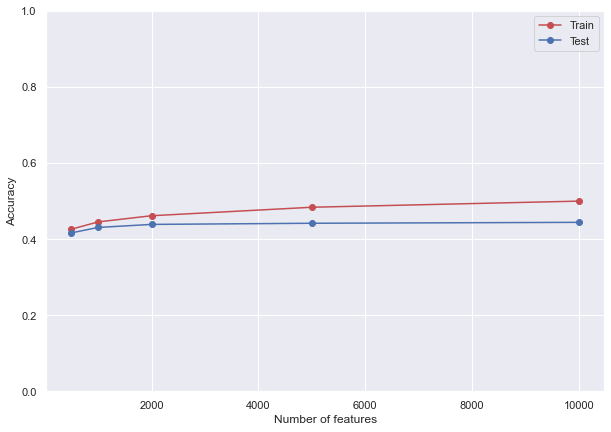

In [97]:
plt.figure(figsize = (10, 7))
plt.plot(num_max_features, acc_titles_train, 'o-', label = 'Train', color = 'r')
plt.plot(num_max_features, acc_titles_test, 'o-', label = 'Test', color = 'b')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Accuracy')

In [98]:
print(acc_titles_train)
print(acc_titles_test)

[0.426045, 0.445185, 0.46137, 0.48368, 0.499775]
[0.4164, 0.4306, 0.4386, 0.4416, 0.444]


### - Conclusiones

`LinearSVC` y `LogisticRegression` con la variable `norm_reviews_titles` obtuieron mejores resultados. Aun cuando este último tuvo un <i>accuracy</i> ligeramente mejor, el tiempo de ejecución fue considerablemente mayor por lo que se considera que el mejor modelo fue `LinearSVC`.

Es por ello que este último modelo será el que optimicemos.

In [99]:
gc.collect()

5149

## - Optimización del modelo

### - Linear Support Vector Classification

In [100]:
list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)

vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 2000)
vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
X_train = vect_rev_titles_train.toarray()
y_train = df_train_unif['stars'].values

svc = LinearSVC(dual = False, random_state = 42)

param_grid = {'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge'],
              'tol': [1e-3, 1e-2, 1e-1], 'C': [1e-2, 1e-1, 1], 'fit_intercept': [False, True]}

svc_gs = GridSearchCV(estimator = svc, param_grid = param_grid, scoring = 'accuracy',
                      n_jobs = -1, cv = 5)

svc_gs.fit(X_train, y_train)

print('The best parameters are:', svc_gs.best_params_, '\n')
print('The best accuracy is:', svc_gs.best_score_)

The best parameters are: {'C': 0.1, 'fit_intercept': False, 'loss': 'squared_hinge', 'penalty': 'l1', 'tol': 0.01} 

The best accuracy is: 0.5162000000000001


Ahora, entrenemos a nuestro modelo con los mejores parámetros y veamos qué resultados nos arroja.

In [101]:
svc = LinearSVC(dual = False, penalty = svc_gs.best_params_['penalty'],
                loss = svc_gs.best_params_['loss'], tol = svc_gs.best_params_['tol'],
                C = svc_gs.best_params_['C'],
                fit_intercept = svc_gs.best_params_['fit_intercept'], random_state = 42)

list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)
list_rev_titles_test = list(df_dev_unif['norm_reviews_titles'].values)

vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 2000)
vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
X_train = vect_rev_titles_train.toarray()
y_train = df_train_unif['stars'].values

svc.fit(X_train, y_train)

vect_rev_titles_test = vectorizer.transform(list_rev_titles_test)
X_test = vect_rev_titles_test.toarray()
y_test = df_dev_unif['stars'].values

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print('Train accuracy:', accuracy_score(y_train, y_train_pred))
print('Test accuracy:', accuracy_score(y_test, y_test_pred))

Train accuracy: 0.53391
Test accuracy: 0.515


In [102]:
svc = LinearSVC(dual = False, penalty = svc_gs.best_params_['penalty'],
                loss = svc_gs.best_params_['loss'], tol = svc_gs.best_params_['tol'],
                C = svc_gs.best_params_['C'],
                fit_intercept = svc_gs.best_params_['fit_intercept'], random_state = 42)

list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)
list_rev_titles_the_test = list(df_test_unif['norm_reviews_titles'].values)

vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 2000)
vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
X_train = vect_rev_titles_train.toarray()
y_train = df_train_unif['stars'].values

svc.fit(X_train, y_train)

vect_rev_titles_the_test = vectorizer.transform(list_rev_titles_the_test)
X_test = vect_rev_titles_the_test.toarray()
y_test = df_test_unif['stars'].values

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print('Train accuracy:', accuracy_score(y_train, y_train_pred))
print('Test accuracy:', accuracy_score(y_test, y_test_pred))

Train accuracy: 0.53391
Test accuracy: 0.5202


Miremos ahora la matriz de confusión.

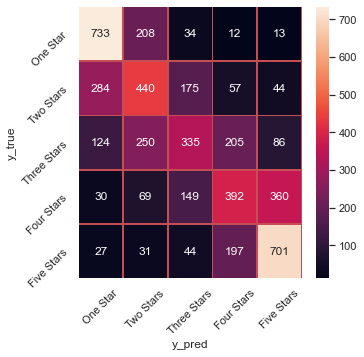

In [103]:
confusion_5(y_test, y_test_pred)

De la matriz de confusión se sigue que las estrellas 1 y 5 fueron las mejor predichas por el modelo seguidas por las estrellas dos y cuatro y, finalmente, la estrella 3. Esto hace sentido pues mientras más radicales son los <i>reviews</i> es más claro qué estrella les corresponde.

### - Importancia de los <i>features</i>

Veamos ahora qué <i>features</i> consideró más importantes nuestro modelo.

Consideremos primero el caso para una estrella.

In [104]:
coeff = svc.coef_[0]
labels = vectorizer.get_feature_names()

feat_importance = pd.DataFrame()
feat_importance['Importance'] = coeff
feat_importance['Features'] = labels
feat_importance.reset_index(drop = True)
feat_importance_sorted = feat_importance.sort_values(by = ['Importance'], ascending = False)
feat_importance_sorted = feat_importance_sorted.reset_index(drop = True)

Text(0.5, 1.0, 'Features importance')

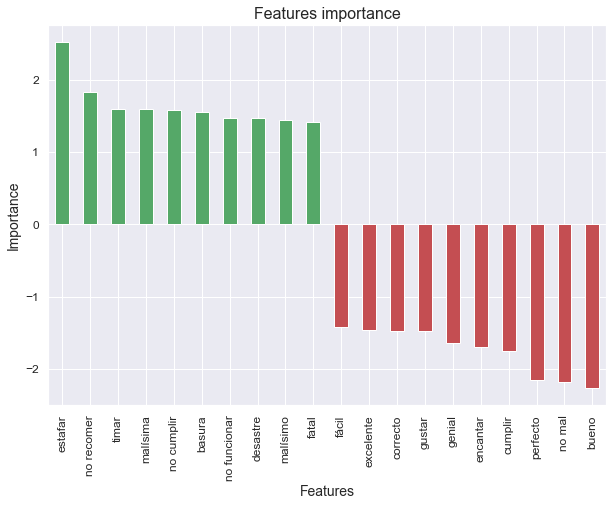

In [105]:
features_plot = pd.concat([feat_importance_sorted.head(10), feat_importance_sorted.tail(10)])
features_plot.sort_values(by = ['Importance'], ascending = False, inplace = True)
features_plot['Positive'] = features_plot['Importance'] > 0
features_plot.set_index('Features', inplace = True)
features_plot.Importance.plot(kind = 'bar', figsize = (10, 7),
                              color = features_plot.Positive.map({True: 'g', False: 'r'}),
                              fontsize = 12)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Importance', rotation = 90, fontsize = 14)
plt.title('Features importance', fontsize = 16)

Para el caso de dos estrellas tenemos lo siguiente.

In [106]:
coeff = svc.coef_[1]
labels = vectorizer.get_feature_names()

feat_importance = pd.DataFrame()
feat_importance['Importance'] = coeff
feat_importance['Features'] = labels
feat_importance.reset_index(drop = True)
feat_importance_sorted = feat_importance.sort_values(by = ['Importance'], ascending = False)
feat_importance_sorted = feat_importance_sorted.reset_index(drop = True)

Text(0.5, 1.0, 'Features importance')

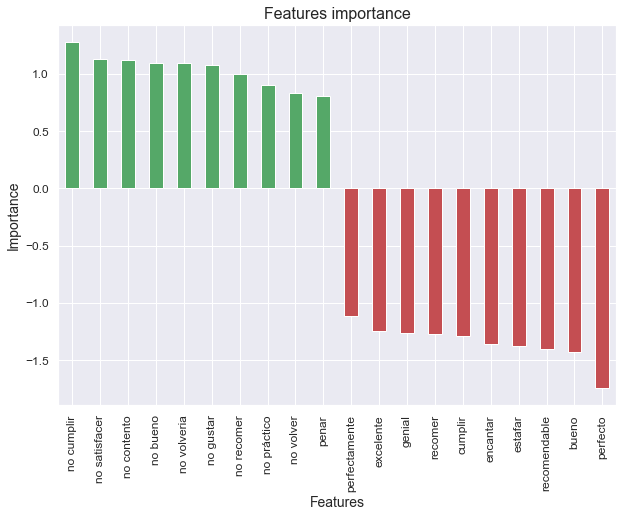

In [107]:
features_plot = pd.concat([feat_importance_sorted.head(10), feat_importance_sorted.tail(10)])
features_plot.sort_values(by = ['Importance'], ascending = False, inplace = True)
features_plot['Positive'] = features_plot['Importance'] > 0
features_plot.set_index('Features', inplace = True)
features_plot.Importance.plot(kind = 'bar', figsize = (10, 7),
                              color = features_plot.Positive.map({True: 'g', False: 'r'}),
                              fontsize = 12)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Importance', rotation = 90, fontsize = 14)
plt.title('Features importance', fontsize = 16)

Para tres estrellas lo siguiente.

In [108]:
coeff = svc.coef_[2]
labels = vectorizer.get_feature_names()

feat_importance = pd.DataFrame()
feat_importance['Importance'] = coeff
feat_importance['Features'] = labels
feat_importance.reset_index(drop = True)
feat_importance_sorted = feat_importance.sort_values(by = ['Importance'], ascending = False)
feat_importance_sorted = feat_importance_sorted.reset_index(drop = True)

Text(0.5, 1.0, 'Features importance')

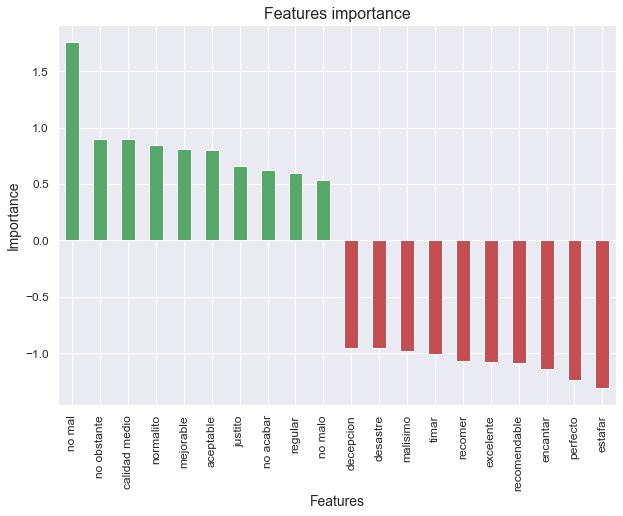

In [109]:
features_plot = pd.concat([feat_importance_sorted.head(10), feat_importance_sorted.tail(10)])
features_plot.sort_values(by = ['Importance'], ascending = False, inplace = True)
features_plot['Positive'] = features_plot['Importance'] > 0
features_plot.set_index('Features', inplace = True)
features_plot.Importance.plot(kind = 'bar', figsize = (10, 7),
                              color = features_plot.Positive.map({True: 'g', False: 'r'}),
                              fontsize = 12)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Importance', rotation = 90, fontsize = 14)
plt.title('Features importance', fontsize = 16)

Para cuatro estrellas los <i>features</i> más importantes son:

In [110]:
coeff = svc.coef_[3]
labels = vectorizer.get_feature_names()

feat_importance = pd.DataFrame()
feat_importance['Importance'] = coeff
feat_importance['Features'] = labels
feat_importance.reset_index(drop = True)
feat_importance_sorted = feat_importance.sort_values(by = ['Importance'], ascending = False)
feat_importance_sorted = feat_importance_sorted.reset_index(drop = True)

Text(0.5, 1.0, 'Features importance')

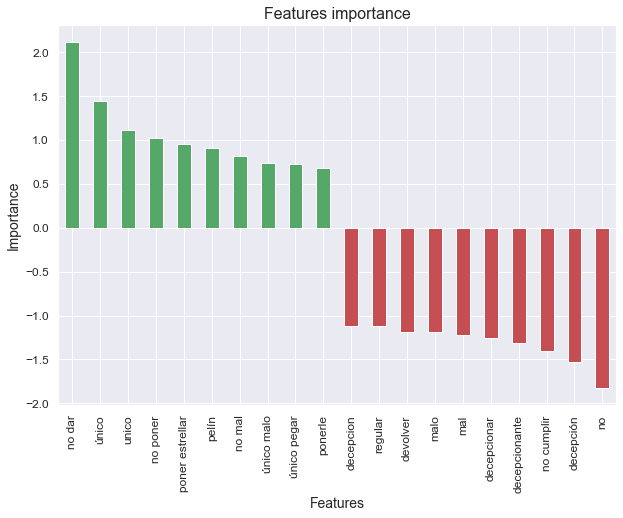

In [111]:
features_plot = pd.concat([feat_importance_sorted.head(10), feat_importance_sorted.tail(10)])
features_plot.sort_values(by = ['Importance'], ascending = False, inplace = True)
features_plot['Positive'] = features_plot['Importance'] > 0
features_plot.set_index('Features', inplace = True)
features_plot.Importance.plot(kind = 'bar', figsize = (10, 7),
                              color = features_plot.Positive.map({True: 'g', False: 'r'}),
                              fontsize = 12)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Importance', rotation = 90, fontsize = 14)
plt.title('Features importance', fontsize = 16)

Y finalmente, para el caso de cinco estrellas se tiene lo siguiente.

In [112]:
coeff = svc.coef_[4]
labels = vectorizer.get_feature_names()

feat_importance = pd.DataFrame()
feat_importance['Importance'] = coeff
feat_importance['Features'] = labels
feat_importance.reset_index(drop = True)
feat_importance_sorted = feat_importance.sort_values(by = ['Importance'], ascending = False)
feat_importance_sorted = feat_importance_sorted.reset_index(drop = True)

Text(0.5, 1.0, 'Features importance')

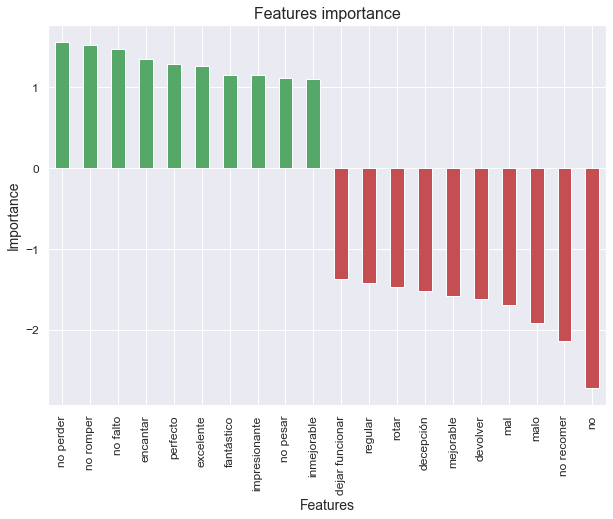

In [113]:
features_plot = pd.concat([feat_importance_sorted.head(10), feat_importance_sorted.tail(10)])
features_plot.sort_values(by = ['Importance'], ascending = False, inplace = True)
features_plot['Positive'] = features_plot['Importance'] > 0
features_plot.set_index('Features', inplace = True)
features_plot.Importance.plot(kind = 'bar', figsize = (10, 7),
                              color = features_plot.Positive.map({True: 'g', False: 'r'}),
                              fontsize = 12)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Importance', rotation = 90, fontsize = 14)
plt.title('Features importance', fontsize = 16)

### - Conlcusiones

Aun cuando el modelo se optimizó mediante `GridSearchCV` este no mejoró respecto a los valores que sus hiperparámetros tienen por defecto. Suponemos que es debido a que dichos valores por defecto se ajustan bien a nuestos datos así como al hecho de que al escoger el número adecuando de <i>features</i> para el modelo hemos ayudado mucho a la regularización.

Que el modelo haya trabajado con el mismo desempeño en el <i>dataset dev</i> que en el de <i>test</i>, e incluso en este último ligeramente mejor, es destacable como positivo.

Finalmente, el modelo claramente tuvo un desempeño mucho mejor que el del <i>benchmark</i> por lo que también satisfizo ese objetivo.

In [114]:
gc.collect()

6020

## Parte C - Investigación

### - Binarización

Exploraremos ahora la posibilidad de que nuestro modelo prediga no una variable multiclase sino una binaria. Para ello, lo que haremos será agrupar las estrellas en una nueva categoría o variable. Del análisis exploratorio del <i>dataset train</i> se desprende que de las 30 palabras más frecuentes para cada estrella aquellas 30 para la calificacion de 3 estrellas son más parecidas a las más frecuentes para 1 y 2 estrellas que para las de 4 y 5 estrellas por lo que las estrellas 1, 2 y 3 formarán una categoría, <i>negative</i>, mientras que las estrellas 4 y 5 formaran otra, <i>positive</i>.

**Hipótesis:** creemos que este enfoque hará que nuestro modelo responda mejor, dado que es aparentemente más sencillo clasificar en dos posibles categorías que en cinco. Veamos si esto ocurre.

Comenzaremos creando la nueva variable, que llamaremos `sentiment`, en nuestros tres <i>datassets</i> la cual tendrá dos posibles valores: <i>positivo</i> o <i>negativo</i>.

In [115]:
df_train_unif['sentiment'] = df_train_unif.stars.apply(lambda x: 'negative' if x in [1, 2, 3] else 'positive')
df_train_unif.tail()

,stars,review_body,review_title,product_category,norm_body,norm_title,norm_reviews_titles,sentiment
199995,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,electrónicos,mandar funcionar perfectamente cumplir funcion...,describir,mandar funcionar perfectamente cumplir funcion...,positive
199996,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,electrónicos,comprar batería reticencia resultar fácil inst...,funcionar perfectamente,comprar batería reticencia resultar fácil inst...,positive
199997,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,ropa,bueno calidad satisfacer comprar,bueno calidad,bueno calidad satisfacer comprar bueno calidad,positive
199998,5,Perfecto para el cumple de mi hijo,Recomendado,juguetes,perfecto cumplir hijo,recomendar,perfecto cumplir hijo recomendar,positive
199999,5,"Súper bien Las brochas son buenas, no sé menos...",Preciosas,hogar,súper brocha no caer pelitos pesar chulo xd,precioso,súper brocha no caer pelitos pesar chulo xd pr...,positive


In [116]:
df_dev_unif['sentiment'] = df_dev_unif.stars.apply(lambda x: 'negative' if x in [1, 2, 3] else 'positive')
df_dev_unif.tail()

,stars,review_body,review_title,product_category,norm_body,norm_title,norm_reviews_titles,sentiment
4995,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,hogar,encantar cesta llegar tamaño util no pesar fir...,guadalupe,encantar cesta llegar tamaño util no pesar fir...,positive
4996,5,Desempeña su función correctamente,calidad precio,cámaras,desempeñar función correctamente,calidad preciar,desempeñar función correctamente calidad preciar,positive
4997,5,Me ha encantado la diadema Las flores son tal ...,Excelente,juguetes,encantar diadema flor venir imagen no venir ap...,excelente,encantar diadema flor venir imagen no venir ap...,positive
4998,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,inalámbrico,gustar fundir tpu fundir normalmente fino colo...,genial,gustar fundir tpu fundir normalmente fino colo...,positive
4999,5,El artículo ha cumplido con las expectativas q...,Buena calidad,ropa,artículo cumplir expectativa desear,bueno calidad,artículo cumplir expectativa desear bueno calidad,positive


In [117]:
df_test_unif['sentiment'] = df_test_unif.stars.apply(lambda x: 'negative' if x in [1, 2, 3] else 'positive')
df_test_unif.tail()

,stars,review_body,review_title,product_category,norm_body,norm_title,norm_reviews_titles,sentiment
4995,5,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,inalámbrico,costar perfecto cumplir función sobrar pecar c...,perfecto servir,costar perfecto cumplir función sobrar pecar c...,positive
4996,5,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",inalámbrico,material flexible cómodo acorde descripción,vendedor rápido fiable,material flexible cómodo acorde descripción ve...,positive
4997,5,Se ve bien el grabado,medallas con bonito grabado,hogar,ver grabar,medalla bonito grabar,ver grabar medalla bonito grabar,positive
4998,5,lo compré para mi bici pero finalmente se lo h...,timbre,deportes,comprar bici finalmente quedar xiaomi scooter ...,timbrar,comprar bici finalmente quedar xiaomi scooter ...,positive
4999,5,Pues este tipo de cascos si que son inalambric...,Auriculares sin cables de verdad,electrónicos,tipo casco si inalambricos no atar goma tipica...,auricular cable,tipo casco si inalambricos no atar goma tipica...,positive


A continuación, verifiquemos si nuestros <i>datasets<i> están balanceados respecto a nuestra nueva variable objetivo.

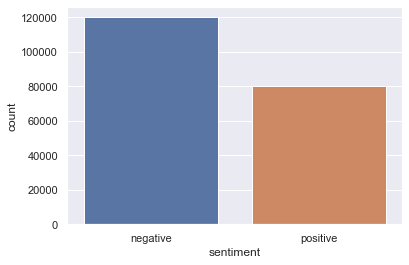

In [118]:
sns.countplot(df_train_unif.sentiment)
plt.show()

Tenemos una relación de sentimientos positivos/negativos de 60/40. Esta proporción todavía puede considerarse balanceada.

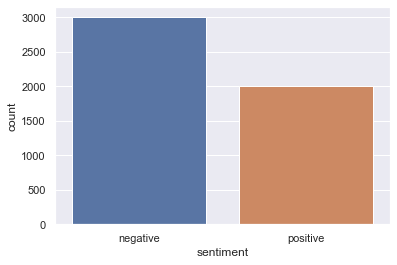

In [119]:
sns.countplot(df_dev_unif.sentiment)
plt.show()

Como en el <i>dataset</i> anterior, tenemos una relación de sentimientos positivos/negativos de 60/40.

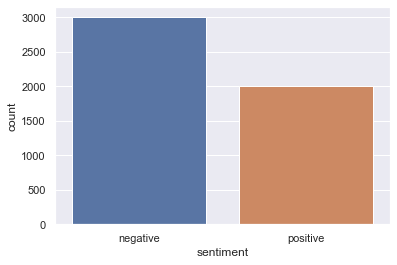

In [120]:
sns.countplot(df_test_unif.sentiment)
plt.show()

Este es exactamente el mismo caso que el del <i>dataset</i> anterior.

Del análisis previo se desprende que una buena métrica a emplear sigue siendo el <i>accuracy</i> por lo que continuaremos con esta.

Ahora, veamos cómo predice nuestro modelo seleccionado, `LinearSVC`, nuestra nueva variable. Pero antes, correremos el modelo <i>benchmark</i> para este caso.

In [121]:
nb = GaussianNB()

# Convertimos en lista los valores de las columnas 'norm_reviews_titles' de ambos datasets.
list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)
list_rev_titles_the_test = list(df_test_unif['norm_reviews_titles'].values)

# Vectorizamos los features de la variable de entrenamiento y definimos tanto el número de
# estos que consideraremos como nuestros conjuntos de entrenamiento.
vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 10000)
vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
X_train = vect_rev_titles_train.toarray()
y_train = df_train_unif['sentiment'].values

# Entrenamos al modelo.
nb.fit(X_train, y_train)

# Vectorizamos los features de la variable objetivo y definimos los conjutnos de prueba.
vect_rev_titles_the_test = vectorizer.transform(list_rev_titles_the_test)
X_test = vect_rev_titles_the_test.toarray()
y_test = df_test_unif['sentiment'].values

# Predecimos los valores de los conjuntos X_train y X_test.
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

# Imprimimos los accuracys.
print('Train accuracy:', accuracy_score(y_train, y_train_pred))
print('Test accuracy:', accuracy_score(y_test, y_test_pred))

Train accuracy: 0.78437
Test accuracy: 0.774


Y ahora, definimos la matriz de confusión y la ejecutamos.

In [122]:
def confusion_2(ytest, y_pred):
    names = ['Negativo', 'Positivo']
    cm = confusion_matrix(ytest, y_pred)
    f, ax = plt.subplots(figsize = (5, 5))
    sns.heatmap(cm, annot = True, linewidth = .5, linecolor = "r", fmt = ".0f", ax = ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names, rotation = 45)
    ax.set_yticklabels(names, rotation = 45)
    plt.show()

    return

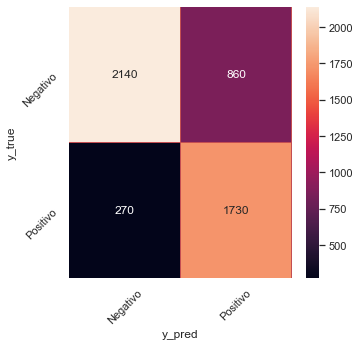

In [123]:
confusion_2(y_test, y_test_pred)

De la matriz de confusión se sigue que la categoría <i>positive</i> fue mejor predicha que la categoría <i>negative</i>, lo cual se esperaba pues esta última agrupa las primeras tres estrellas mientras que la primera agrupa a las últimas dos que tienen una tendencia más clara.

Como hicimos en el análisis multiclase, seleccionemos el mejor número de <i>features</i> para nuestra variable `norm_reviews_titles`.

In [124]:
# Convertimos en lista los valores de las columnas 'norm_reviews_titles' de ambos datasets.
list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)
list_rev_titles_test = list(df_dev_unif['norm_reviews_titles'].values)

# Definimos dos listas vacías que guardarán los accuracys de train y test.
acc_rev_titles_train = []
acc_rev_titles_test = []

# Definimmos la lista con los números de features que probaremos.
num_max_features = [4000, 5000, 7500, 10000]

# Probamos los distintos valores.
for i in num_max_features:
    vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = i)
    vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
    vect_rev_titles_test = vectorizer.transform(list_rev_titles_test)
    X_train = vect_rev_titles_train.toarray()
    y_train = df_train_unif['sentiment'].values
    X_test = vect_rev_titles_test.toarray()
    y_test = df_dev_unif['sentiment'].values
    
    # Definimos el modelo a probar y lo entrenamos.
    svc = LinearSVC(dual = False, random_state = 42)
    svc.fit(X_train, y_train)
    
    # Obtenemos los valores predichos para train.
    y_pred_rev_titles_train = svc.predict(X_train)
    accuracy_rev_titles_train = accuracy_score(y_train, y_pred_rev_titles_train)
    
    # Obtenemos los valores predichos para test.
    y_pred_rev_titles_test = svc.predict(X_test)
    accuracy_rev_titles_test = accuracy_score(y_test, y_pred_rev_titles_test)
    
    # Copiamos los accuracys en nuestras listas.
    acc_rev_titles_train.append(accuracy_rev_titles_train)
    acc_rev_titles_test.append(accuracy_rev_titles_test)

Text(0, 0.5, 'Accuracy')

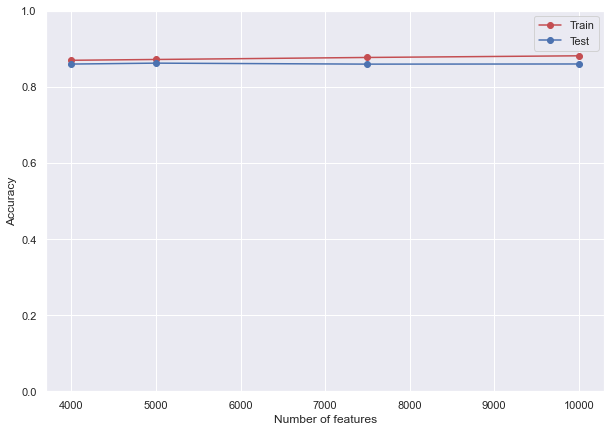

In [125]:
plt.figure(figsize = (10, 7))
plt.plot(num_max_features, acc_rev_titles_train, 'o-', label = 'Train', color = 'r')
plt.plot(num_max_features, acc_rev_titles_test, 'o-', label = 'Test', color = 'b')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Accuracy')

In [126]:
print(acc_rev_titles_train)
print(acc_rev_titles_test)

[0.86992, 0.87203, 0.87732, 0.881675]
[0.86, 0.8624, 0.8598, 0.8602]


In [127]:
gc.collect()

9992

Corremos ahora un `GridSearchCV` para encontrar los mejores parámetros para nuestro modelo.

In [128]:
list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)

vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000)
vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
X_train = vect_rev_titles_train.toarray()
y_train = df_train_unif['sentiment'].values

svc = LinearSVC(dual = False, random_state = 42)

param_grid = {'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge'],
              'tol': [1e-3, 1e-2, 1e-1], 'C': [1e-2, 1e-1, 1],
              'fit_intercept': [False, True]}

svc_gs = GridSearchCV(estimator = svc, param_grid = param_grid, scoring = 'accuracy', cv = 5)

svc_gs.fit(X_train, y_train)

print('The best parameters are:', svc_gs.best_params_, '\n')
print('The best accuracy is:', svc_gs.best_score_)

The best parameters are: {'C': 0.1, 'fit_intercept': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.01} 

The best accuracy is: 0.844365


Y ahora, entrenamos a nuestro modelo tomando los mejores parámetros del `GridSearchCV`.

In [129]:
svc = LinearSVC(dual = False, penalty = svc_gs.best_params_['penalty'],
                loss = svc_gs.best_params_['loss'], tol = svc_gs.best_params_['tol'],
                C = svc_gs.best_params_['C'],
                fit_intercept = svc_gs.best_params_['fit_intercept'], random_state = 42)

list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)
list_rev_titles_test = list(df_dev_unif['norm_reviews_titles'].values)

vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000)
vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
X_train = vect_rev_titles_train.toarray()
y_train = df_train_unif['sentiment'].values

svc.fit(X_train, y_train)

vect_rev_titles_test = vectorizer.transform(list_rev_titles_test)
X_test = vect_rev_titles_test.toarray()
y_test = df_dev_unif['sentiment'].values

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print('Train accuracy:', accuracy_score(y_train, y_train_pred))
print('Test accuracy:', accuracy_score(y_test, y_test_pred))

Train accuracy: 0.870435
Test accuracy: 0.8636


Y finalmente, probamos a nuestro modelo con el conjunto <i>Test</i>.

In [130]:
svc = LinearSVC(dual = False, penalty = svc_gs.best_params_['penalty'],
                loss = svc_gs.best_params_['loss'], tol = svc_gs.best_params_['tol'],
                C = svc_gs.best_params_['C'],
                fit_intercept = svc_gs.best_params_['fit_intercept'], random_state = 42)

list_rev_titles_train = list(df_train_unif['norm_reviews_titles'].values)
list_rev_titles_the_test = list(df_test_unif['norm_reviews_titles'].values)

vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000)
vect_rev_titles_train = vectorizer.fit_transform(list_rev_titles_train)
X_train = vect_rev_titles_train.toarray()
y_train = df_train_unif['sentiment'].values

svc.fit(X_train, y_train)

vect_rev_titles_the_test = vectorizer.transform(list_rev_titles_the_test)
X_test = vect_rev_titles_the_test.toarray()
y_test = df_test_unif['sentiment'].values

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print('Train accuracy:', accuracy_score(y_train, y_train_pred))
print('Test accuracy:', accuracy_score(y_test, y_test_pred))

Train accuracy: 0.870435
Test accuracy: 0.8612


Definimos ahora la función que usaremos para correr la matriz de confusión y la usamos.

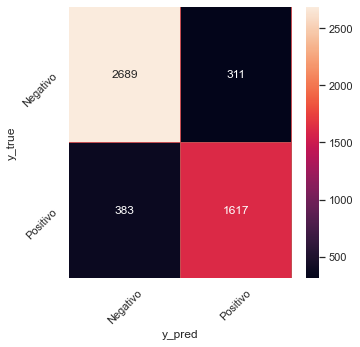

In [131]:
confusion_2(y_test, y_test_pred)

A diferencia del modelo <i>benchmark</i>, la categoría mejor predicha por este modelo es <i>negativo</i>.

### - Importancia de los <i>features</i>

Veamos ahora qué <i>features</i> consideró más relevantes nuestro modelo para este caso binario.

In [132]:
coeff = svc.coef_[0]
labels = vectorizer.get_feature_names()

feat_importance = pd.DataFrame()
feat_importance['Importance'] = coeff
feat_importance['Features'] = labels
feat_importance.reset_index(drop = True)
feat_importance_sorted = feat_importance.sort_values(by = ['Importance'], ascending = False)
feat_importance_sorted = feat_importance_sorted.reset_index(drop = True)

Text(0.5, 1.0, 'Features importance')

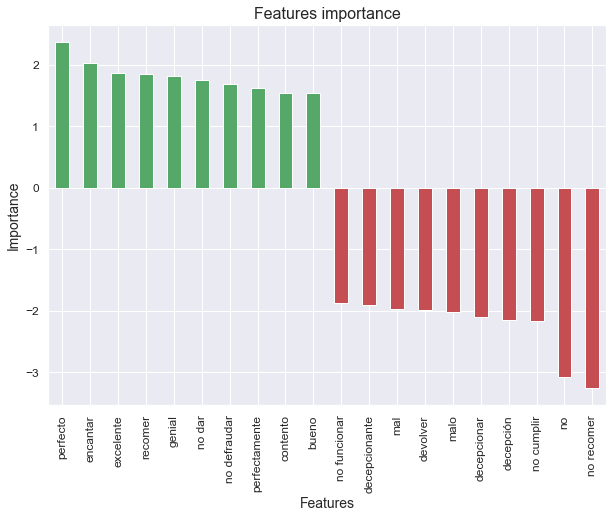

In [133]:
features_plot = pd.concat([feat_importance_sorted.head(10), feat_importance_sorted.tail(10)])
features_plot.sort_values(by = ['Importance'], ascending = False, inplace = True)
features_plot['Positive'] = features_plot['Importance'] > 0
features_plot.set_index('Features', inplace = True)
features_plot.Importance.plot(kind = 'bar', figsize = (10, 7),
                              color = features_plot.Positive.map({True: 'g', False: 'r'}),
                              fontsize = 12)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Importance', rotation = 90, fontsize = 14)
plt.title('Features importance', fontsize = 16)

### - Conclusiones

Definitivamente, el modelo predijo mucho mejor la variable binaria que la multiclase. Creemos que esto se debe a que es más fácil, incluso para los humanos, clasificar algo en una de dos posibilidades que en una de cinco dadas. Por otro lado, es probable que algunos usuarios hayan discrepado sobre el criterio para asignarle un número de estrellas al tono de un <i>review</i>.

Así, en un caso real lo que se recomendaría es sustuir el mecanismo para el usuario de asignar una de cinco posibles calificaciones a su satisfacción respecto a algún producto por el mecanismo de señalar si terminó satisfecho o insatisfecho con él, por ejemplo.

Finalmente, para pronta referencia dejamos las matrices de confusión de los modelos <i>benchmark</i> así como las de los modelos `LinearSVC`, tanto en la versión multiclase como en la binaria. 

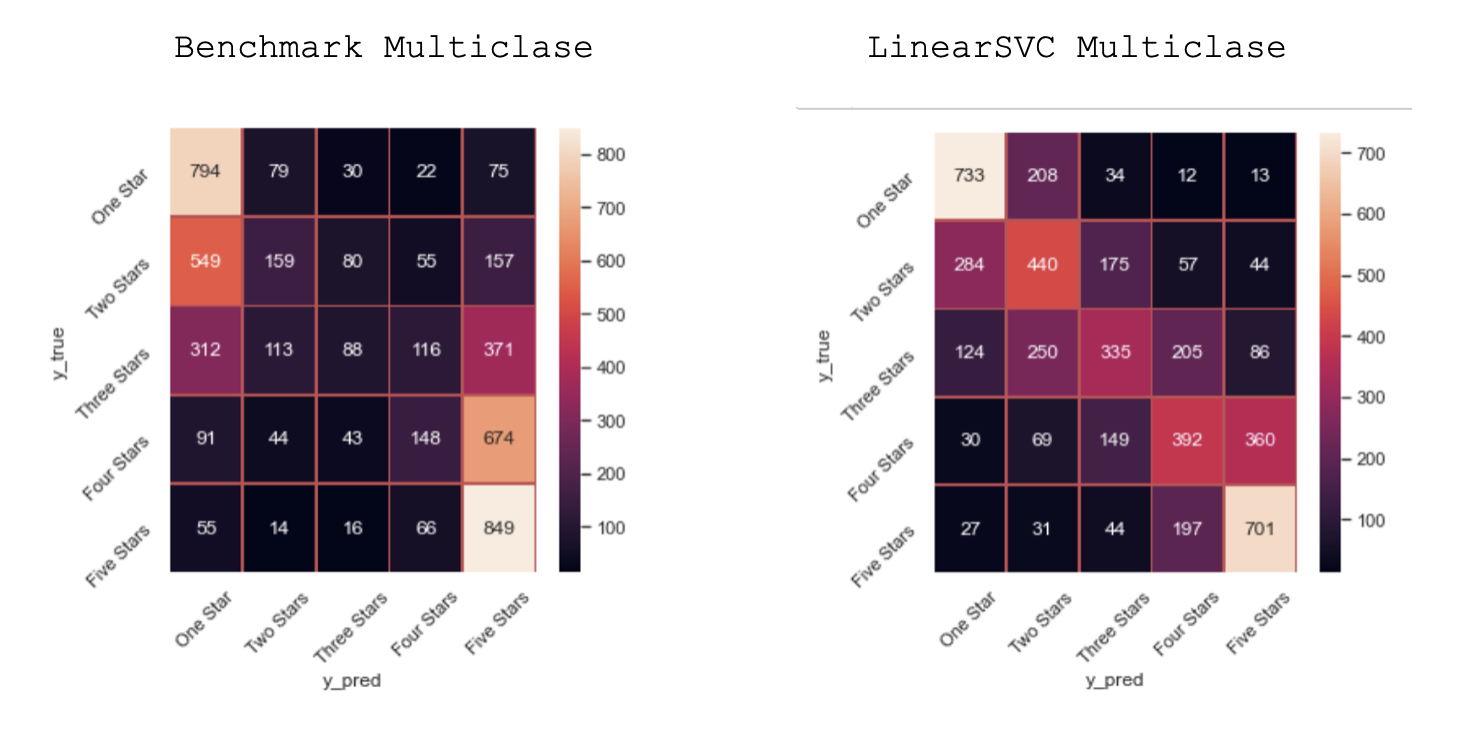

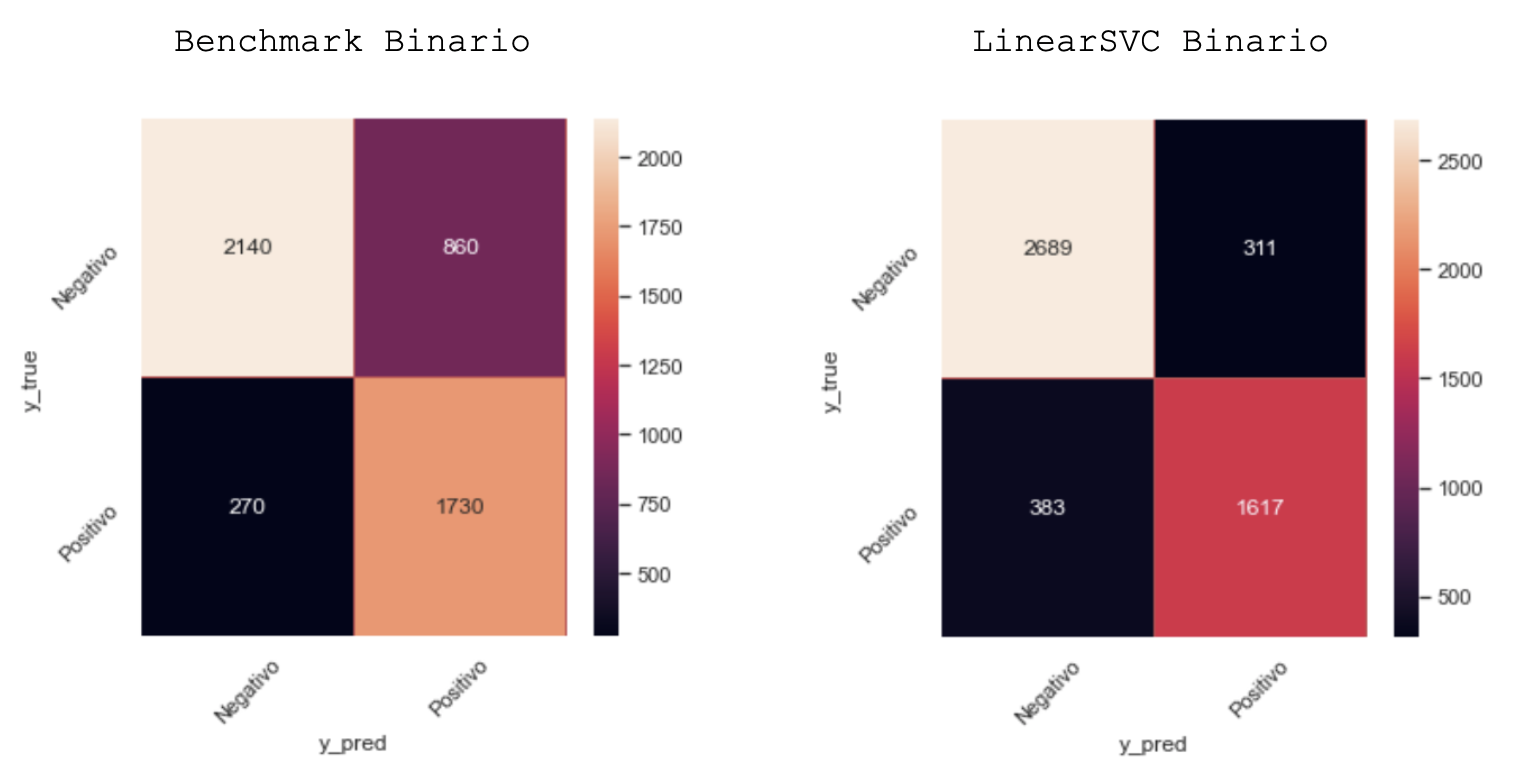

### - Para investigar

Como comentario final, se considera que el <b>análisis de sentimientos</b> puede ser muy interesante para este problema. Sin embargo, después de investigar al respecto parece que aún no hay alguna librería que funcione eficientemente con el idioma español.

En un futuro, con más tiempo para investigar y probar, podría ser una implementación a considerar.